<a href="https://colab.research.google.com/github/arijguest/MY2025/blob/main/MY25_GeochemPlotter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



***MY2025 Geochemical Plotting Tool ***


---

For data from the LIBS/APXS instruments. Run the first two code blocks (Install Packages (followed by a session restart) then Data Import) to run any other module you'd like! To hide the code to make this notebook easier to navigate, select a code block and click the **View** tab, then **Show/Hide Code**. You will need to repeat this for all code blocks.



---

Use the simulated data tool to create a test dataset with the specified number of rock types, their separation (how distinct the rock units are) and spread (how similar the measurements within rock groups are).



---


Any issues, ask me! <br>
***Created by Ari Guest***


---





In [ ]:
# @title Install Required Packages - Use View > Show/Hide Code
%pip install pyrolite
%pip install pingouin


###############################################################################
# Run this notebook block-by-block - ensuring you start here!
###############################################################################

In [ ]:
# @title Data Input & Preparation Module

import io
import os
import re
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from pyrolite.util.classification import TAS
from pyrolite.util.synthetic import normal_frame
import ipywidgets as widgets
from IPython.display import display, clear_output

# Set auto layout
plt.rcParams['figure.autolayout'] = True

def normalize(s):
    s = str(s)
    s = re.sub(r"<sub>(.*?)</sub>", r"\1", s, flags=re.IGNORECASE)
    s = re.sub(r"<sup>(.*?)</sup>", r"\1", s, flags=re.IGNORECASE)
    subscript_map = {'₀': '0','₁': '1','₂': '2','₃': '3','₄': '4','₅': '5','₆': '6','₇': '7','₈': '8','₉': '9'}
    for sub, repl in subscript_map.items():
        s = s.replace(sub, repl)
    superscript_map = {'⁰': '0','¹': '1','²': '2','³': '3','⁴': '4','⁵': '5','⁶': '6','⁷': '7','⁸': '8','⁹': '9'}
    for sup, repl in superscript_map.items():
        s = s.replace(sup, repl)
    return re.sub(r"[^a-z0-9_()]", "", s.lower())

def detect_column(df, desired, alternatives):
    norm_cols = {normalize(col): col for col in df.columns}
    candidates = [desired] + alternatives
    for cand in candidates:
        if normalize(cand) in norm_cols:
            return norm_cols[normalize(cand)]
    raise ValueError()

def load_and_prepare_data(file_bytes=None, dataset_label="MyDataset", color="blue", marker="o",
                          si_col="SiO2", na_col="Na2O", k_col="K2O", group_col="Group"):
    if file_bytes is None:
        return None
    text_data = file_bytes.decode("utf-8", errors="replace").splitlines()
    header_line_index = None
    for i, line in enumerate(text_data):
        if "Element" in line and ("Weight" in line or "weight" in line):
            header_line_index = i
            break
    if header_line_index is None:
        for i, line in enumerate(text_data):
            if "File" in line and "Target" in line:
                header_line_index = i
                break
    relevant_data = "\n".join(text_data[header_line_index:]) if header_line_index is not None else "\n".join(text_data)
    try:
        df = pd.read_csv(io.StringIO(relevant_data), sep=None, engine='python', skip_blank_lines=True)
        df = df.dropna(how='all', axis=1)
    except:
        return None

    norm_cols = [normalize(c) for c in df.columns]
    if any("element" == nc for nc in norm_cols):
        element_idx = None
        for idx, nc in enumerate(norm_cols):
            if nc == "element":
                element_idx = idx
                break
        if element_idx is not None and (element_idx + 1) < len(df.columns):
            weight_col_raw = df.columns[element_idx + 1]
            df.rename(columns={weight_col_raw: "Weight-%"}, inplace=True)

        if any(normalize(c) == "sample" for c in df.columns):
            try:
                df = df.pivot_table(values="Weight-%", index="Sample", columns="Element", aggfunc="first")
                df.reset_index(drop=False, inplace=True)
            except:
                pass
        else:
            if "Element" in df.columns and "Weight-%" in df.columns:
                elements = df["Element"].astype(str).values
                weights = df["Weight-%"].values
                df_wide = pd.DataFrame([weights], columns=elements)
                df = df_wide

    oxide_candidates = {
        "SiO2":  ["SiO_2","SiO<sub>2</sub>","SiO₂","SiO₂?","si"],
        "TiO2":  ["TiO_2","TiO<sub>2</sub>","TiO₂","ti"],
        "Al2O3": ["Al2O_3","Al<sub>2</sub>O<sub>3</sub>","Al₂O₃"],
        "FeO":   ["FeO(T)","FeO(t)","FeOT"],
        "Fe2O3": ["Fe2O_3","Fe<sub>2</sub>O<sub>3</sub>","Fe₂O₃"],
        "MnO":   ["Mn0"],
        "MgO":   [],
        "CaO":   [],
        "Na2O":  ["Na<sub>2</sub>O","Na₂O","Na2O?"],
        "K2O":   ["K<sub>2</sub>O","K₂O","K2O?"],
        "P2O5":  ["P2O_5","P<sub>2</sub>O<sub>5</sub>","P₂O₅"]
    }
    detected_oxides = {}
    for oxide, alt_names in oxide_candidates.items():
        try:
            colname = detect_column(df, oxide, alt_names)
            detected_oxides[oxide] = colname
        except:
            if oxide in [si_col, na_col, k_col]:
                raise ValueError()

    rename_map = {}
    for canonical_name, original_col in detected_oxides.items():
        rename_map[original_col] = canonical_name
    df.rename(columns=rename_map, inplace=True)

    if "Na2O" in df.columns and "K2O" in df.columns:
        df["Na2O + K2O"] = df["Na2O"] + df["K2O"]
    else:
        df["Na2O + K2O"] = np.nan

    df[group_col] = dataset_label
    df["_style_color"] = color
    df["_style_marker"] = marker
    df.attrs["detected_oxides"] = detected_oxides
    return df

def generate_simulated_data(dataset_label="SimulatedData", color="black", marker="o",
                            si_col="SiO2", na_col="Na2O", k_col="K2O", group_col="Group",
                            size=100, spread=1.0, separation=1.0, num_rock_types=1):
    rng = np.random.default_rng(123)
    subset_size = size // num_rock_types
    all_subsets = []
    for i in range(num_rock_types):
        si_base = rng.uniform(35, 80)
        si_center = si_base + i * (10.0 * separation)
        ta_base = rng.uniform(0, 12)
        ta_center = ta_base + i * (2.0 * separation)
        alk_ratio = rng.uniform(0.2, 0.8)
        na_center = ta_center * alk_ratio
        k_center = ta_center * (1 - alk_ratio)
        base_means_others = {
            "Al2O3": 15 + rng.normal(0, 1) * i,
            "TiO2": 1  + rng.normal(0, 0.2) * i,
            "FeO": 7  + rng.normal(0, 1) * i,
            "Fe2O3": 0.5 + rng.normal(0, 0.5) * i,
            "MnO": 0.1 + rng.normal(0, 0.01) * i,
            "MgO": 4   + rng.normal(0, 1) * i,
            "CaO": 4   + rng.normal(0, 1) * i,
            "P2O5": 0.3 + rng.normal(0, 0.1) * i
        }
        data = {
            si_col: np.clip(rng.normal(si_center, 5 * spread, subset_size), 0, None),
            na_col: np.clip(rng.normal(na_center, 0.5 * spread, subset_size), 0, None),
            k_col: np.clip(rng.normal(k_center, 0.5 * spread, subset_size), 0, None)
        }
        for oxide_name, oxide_mean in base_means_others.items():
            if oxide_name in ["FeO", "MgO", "CaO", "Al2O3"]:
                std_val = 2 * spread
            else:
                std_val = 0.5 * spread
            data[oxide_name] = np.clip(rng.normal(oxide_mean, std_val, subset_size), 0, None)

        sub_df = pd.DataFrame(data)
        sub_df[group_col] = f"{dataset_label}_Type{i+1}"
        sub_df["RockType"] = f"Type{i+1}"
        sub_df["_style_color"] = color
        sub_df["_style_marker"] = marker
        sub_df["Na2O + K2O"] = sub_df[na_col] + sub_df[k_col]
        all_subsets.append(sub_df)

    df_combined = pd.concat(all_subsets, ignore_index=True)
    df_combined.attrs["detected_oxides"] = {
        si_col: si_col,
        "TiO2": "TiO2",
        "Al2O3": "Al2O3",
        "FeO": "FeO",
        "Fe2O3": "Fe2O3",
        "MnO": "MnO",
        "MgO": "MgO",
        "CaO": "CaO",
        na_col: na_col,
        k_col: k_col,
        "P2O5": "P2O5"
    }
    return df_combined

def parse_rock_sol_measurement(group_val):
    if not isinstance(group_val, str):
        return None, None, None
    parts = group_val.split("-")
    if len(parts) < 4:
        return None, None, None
    sol_str = parts[1].strip()
    rock_type_raw = parts[2].strip()
    measurement_str = parts[3].strip()
    if len(rock_type_raw) > 1:
        rock_type_raw = rock_type_raw[:-1]
    return sol_str, rock_type_raw, measurement_str

rock_types_all = set()
sol_all = set()

measurement_select_widget = widgets.SelectMultiple(
    options=["1", "2", "3"],
    value=["1", "2", "3"],
    description="Measurements",
    layout=widgets.Layout(width="150px", height="80px")
)

rock_type_select_widget = widgets.SelectMultiple(
    options=[],
    value=[],
    description="Rock Types",
    layout=widgets.Layout(width="200px", height="100px")
)

sol_select_widget = widgets.SelectMultiple(
    options=[],
    value=[],
    description="Sol",
    layout=widgets.Layout(width="150px", height="80px")
)

datasets_storage = []
output_area_input = widgets.Output(layout={'border': '1px solid black'})

upload_widget = widgets.FileUpload(
    multiple=True,
    description="Upload CSV or ZIP(s)",
    accept=".csv,.zip",
    style={"button_color": "rgba(71,189,211,255)"}
)

dataset_label_widget = widgets.Text(value="Default: File-name", description="Group Name:")
marker_options = ["o", "^", "s", "d", "*", "v", "<", ">", "P", "X", "H", "+"]
color_options = [
    "blue","red","green","purple","orange","black","cyan","magenta",
    "yellow","gray","brown","gold","darkgreen","darkblue","pink","lime"
]
color_dropdown = widgets.Dropdown(options=color_options, value="blue", description="Color:")
marker_dropdown = widgets.Dropdown(options=marker_options, value="o", description="Marker:")
si_col_widget = widgets.Text(value="SiO2", description="Si Col:")
na_col_widget = widgets.Text(value="Na2O", description="Na Col:")
k_col_widget = widgets.Text(value="K2O", description="K Col:")
add_csv_button = widgets.Button(description="Add CSV/ZIP Dataset(s)", button_style="info")

use_sim_data_checkbox = widgets.Checkbox(value=False, description="Create Sim Data?")
sim_label_widget = widgets.Text(value="SimulatedData", description="Sim Group Name:")
sim_color_dropdown = widgets.Dropdown(options=color_options, value="black", description="Color:")
sim_marker_dropdown = widgets.Dropdown(options=marker_options, value="o", description="Marker:")
sim_size_widget = widgets.IntText(value=1000, description="Sim Size:")
sim_spread_slider = widgets.FloatSlider(value=1.0, min=0.1, max=4.0, step=0.1, description="Spread:", continuous_update=False)
sim_separation_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.1, description="Separation:", continuous_update=False)
num_rock_types_widget = widgets.IntText(value=1, description="Num Rock Types:")
add_sim_button = widgets.Button(description="Add Sim Dataset", button_style="info")

clear_all_button = widgets.Button(
    description="Clear All Datasets",
    button_style="danger"
)

def on_clear_all_button_clicked(_):
    with output_area_input:
        clear_output()
        datasets_storage.clear()
        plt.close('all')
        print("Cleared all datasets")

clear_all_button.on_click(on_clear_all_button_clicked)

used_color_marker_combos = set()

def get_unique_color_marker(color_opts, marker_opts):
    global used_color_marker_combos
    for c in color_opts:
        for m in marker_opts:
            if (c, m) not in used_color_marker_combos:
                used_color_marker_combos.add((c, m))
                return c, m
    print("WARNING: Ran out of unique color/marker combos. Using fallback (black, 'o').")
    return ("black", "o")

def on_add_csv_button_clicked(_):
    global used_color_marker_combos
    with output_area_input:
        clear_output()
        if not upload_widget.value:
            print("No CSV or ZIP file(s) uploaded.")
            return
        for fname, file_info in upload_widget.value.items():
            file_bytes = file_info["content"]
            label_from_file = os.path.splitext(fname)[0]
            override_label = dataset_label_widget.value.strip()
            if override_label and override_label != "Default: File-name":
                label_from_file = override_label
            if fname.lower().endswith(".zip"):
                tmp_zip_path = f"/tmp/{fname}"
                with open(tmp_zip_path, "wb") as f:
                    f.write(file_bytes)
                extract_dir = f"/tmp/extracted_{label_from_file}"
                os.makedirs(extract_dir, exist_ok=True)
                with zipfile.ZipFile(tmp_zip_path, "r") as zip_ref:
                    zip_ref.extractall(extract_dir)
                for root, dirs, files in os.walk(extract_dir):
                    for csvfile in files:
                        if csvfile.lower().endswith(".csv"):
                            full_path = os.path.join(root, csvfile)
                            with open(full_path, "rb") as f_in:
                                csv_bytes = f_in.read()
                            try:
                                c, m = get_unique_color_marker(color_options, marker_options)
                                df = load_and_prepare_data(
                                    file_bytes=csv_bytes,
                                    dataset_label=os.path.splitext(csvfile)[0],
                                    color=c,
                                    marker=m,
                                    si_col=si_col_widget.value,
                                    na_col=na_col_widget.value,
                                    k_col=k_col_widget.value
                                )
                                if df is not None:
                                    datasets_storage.append(df)
                                    print(f"Added CSV '{csvfile}' from ZIP '{fname}' with color='{c}', marker='{m}'.")
                                    print("Detected oxide columns:", df.attrs.get("detected_oxides", {}))
                                else:
                                    print(f"No data found or invalid CSV: '{csvfile}'.")
                            except Exception as e:
                                print(f"Error loading CSV '{csvfile}' from ZIP '{fname}': {e}")
                print(f"Finished processing ZIP '{fname}'.")
            else:
                try:
                    c, m = get_unique_color_marker(color_options, marker_options)
                    df = load_and_prepare_data(
                        file_bytes=file_bytes,
                        dataset_label=label_from_file,
                        color=c,
                        marker=m,
                        si_col=si_col_widget.value,
                        na_col=na_col_widget.value,
                        k_col=k_col_widget.value
                    )
                    if df is not None:
                        datasets_storage.append(df)
                        print(f"Dataset '{label_from_file}' from file '{fname}' added with color='{c}', marker='{m}'.")
                        print("Detected oxide columns:", df.attrs.get("detected_oxides", {}))
                    else:
                        print(f"No data found or invalid CSV: '{fname}'.")
                except Exception as e:
                    print(f"Error adding CSV dataset for file '{fname}': {e}")
        parse_sol_rock_and_measurement_for_all_datasets()
        upload_widget.value.clear()
        upload_widget._counter = 0

add_csv_button.on_click(on_add_csv_button_clicked)

def on_add_sim_button_clicked(_):
    with output_area_input:
        clear_output()
        if not use_sim_data_checkbox.value:
            print("Simulated data checkbox not checked; no simulated data added.")
            return
        label = sim_label_widget.value.strip() or "SimData"
        color = sim_color_dropdown.value
        marker_ = sim_marker_dropdown.value
        size = sim_size_widget.value
        spread = sim_spread_slider.value
        separation_val = sim_separation_slider.value
        num_types = num_rock_types_widget.value
        df_sim = generate_simulated_data(
            dataset_label=label,
            color=color,
            marker=marker_,
            size=size,
            spread=spread,
            separation=separation_val,
            num_rock_types=num_types
        )
        datasets_storage.append(df_sim)
        parse_sol_rock_and_measurement_for_all_datasets()
        print(f"Simulated dataset '{label}' added (size={size}, spread={spread}, separation={separation_val}, rock_types={num_types}), color='{color}', marker='{marker_}'.")
        print("Detected oxide columns:", df_sim.attrs.get("detected_oxides", {}))

add_sim_button.on_click(on_add_sim_button_clicked)

def parse_sol_rock_and_measurement_for_all_datasets():
    global rock_types_all, sol_all
    rock_types_all.clear()
    sol_all.clear()
    for df in datasets_storage:
        if "Group" not in df.columns:
            continue
        if "SolAuto" not in df.columns:
            df["SolAuto"] = None
        if "RockTypeAuto" not in df.columns:
            df["RockTypeAuto"] = None
        if "MeasurementAuto" not in df.columns:
            df["MeasurementAuto"] = None
        for idx in df.index:
            group_val = df.at[idx, "Group"]
            sol_str, rock_val, meas_val = parse_rock_sol_measurement(group_val)
            df.at[idx, "SolAuto"] = sol_str
            df.at[idx, "RockTypeAuto"] = rock_val
            df.at[idx, "MeasurementAuto"] = meas_val
            if rock_val is not None:
                rock_types_all.add(rock_val)
            if sol_str is not None:
                sol_all.add(sol_str)
    sorted_rocks = sorted(list(rock_types_all))
    rock_type_select_widget.options = sorted_rocks
    rock_type_select_widget.value = tuple(sorted_rocks)
    sorted_sols = sorted(list(sol_all))
    sol_select_widget.options = sorted_sols
    sol_select_widget.value = tuple(sorted_sols)

parse_button = widgets.Button(
    description="Parse & Update Sol/Rock/Measurement",
    button_style="info"
)

def on_parse_button_clicked(_):
    with output_area_input:
        clear_output()
        parse_sol_rock_and_measurement_for_all_datasets()
        print("Parsing complete. 'SolAuto', 'RockTypeAuto', and 'MeasurementAuto' columns added.")
        print("Unique rock types discovered:", rock_types_all)
        print("Unique Sol segments discovered:", sol_all)

parse_button.on_click(on_parse_button_clicked)

min_remove_checkbox = widgets.Checkbox(value=False, description="Remove rows w/ 0 in any oxide?")

filter_button = widgets.Button(
    description="Apply Filters: Sol/Rock/Measurement",
    button_style="warning"
)

def on_filter_button_clicked(_):
    with output_area_input:
        clear_output()
        selected_measurements = set(measurement_select_widget.value)
        selected_rocks = set(rock_type_select_widget.value)
        selected_sols = set(sol_select_widget.value)
        for i, df in enumerate(datasets_storage):
            if all(col in df.columns for col in ("SolAuto","RockTypeAuto","MeasurementAuto")):
                before_count = len(df)
                df_filtered = df[
                    df["SolAuto"].isin(selected_sols)
                    & df["RockTypeAuto"].isin(selected_rocks)
                    & df["MeasurementAuto"].isin(selected_measurements)
                ]
                if min_remove_checkbox.value:
                    oxide_cols = set(df.attrs.get("detected_oxides", {}).keys()) & set(df_filtered.columns)
                    df_filtered = df_filtered[(df_filtered[list(oxide_cols)] != 0).all(axis=1)]
                after_count = len(df_filtered)
                datasets_storage[i] = df_filtered.reset_index(drop=True)
                print(f"Filtered dataset {i+1}: {before_count} -> {after_count} rows.")
            else:
                print(f"Dataset {i+1} missing SolAuto/RockTypeAuto/MeasurementAuto columns; skipping.")
        print("Filtering complete.")

filter_button.on_click(on_filter_button_clicked)

filter_section_ui = widgets.VBox([
    widgets.HTML("<b>Measurements to Include:</b>"),
    measurement_select_widget,
    widgets.HTML("<b>Rock Types to Include:</b>"),
    rock_type_select_widget,
    widgets.HTML("<b>Sol to Include:</b>"),
    sol_select_widget,
    min_remove_checkbox,
    filter_button
])

input_ui = widgets.VBox([
    widgets.HTML("<h3>Data Input & Preparation Module</h3>"),
    widgets.HTML("<b>1) Add CSV or ZIP Dataset(s)</b>"),
    widgets.HBox([upload_widget, dataset_label_widget, color_dropdown, marker_dropdown]),
    widgets.HTML("<b>Enter CSV Column Names (Optional)</b>"),
    widgets.HBox([si_col_widget, na_col_widget, k_col_widget]),
    add_csv_button,
    widgets.HTML("<hr><b>2) (Optional) Add Simulated Data Groups</b>"),
    widgets.HBox([
        use_sim_data_checkbox, sim_label_widget, sim_color_dropdown, sim_marker_dropdown,
        sim_size_widget, sim_spread_slider, sim_separation_slider, num_rock_types_widget
    ]),
    add_sim_button,
    widgets.HTML("<hr>"),
    clear_all_button,
    widgets.HTML("<hr><b>Rock & Measurement Parsing</b>"),
    parse_button,
    filter_section_ui,
    output_area_input
])

apxs_html = widgets.HTML("<hr><b>Regolith Removal Module</b>")

apxs_upload_widget = widgets.FileUpload(
    multiple=False,
    description="Upload APXS CSV",
    accept=".csv",
    style={"button_color": "rgba(187,121,71,255)"}
)

remove_regolith_button = widgets.Button(
    description="Remove Regolith",
    button_style="info"
)

def on_remove_regolith_button_clicked(_):
    with output_area_input:
        clear_output()
        if not apxs_upload_widget.value:
            print("No APXS CSV uploaded. Please upload a file before removing regolith.")
            return
        for fname, file_info in apxs_upload_widget.value.items():
            file_bytes = file_info["content"]
            try:
                text_data = file_bytes.decode("utf-8", errors="replace")
                regolith_df = pd.read_csv(io.StringIO(text_data), sep=None, engine="python", skip_blank_lines=True)
                if regolith_df.empty:
                    print("APXS dataset is empty. No changes made.")
                    return
                regolith_apxs = regolith_df.iloc[0]
                for i, df in enumerate(datasets_storage):
                    for col in regolith_apxs.index:
                        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
                            df[col] = df[col] - regolith_apxs[col]
                            df[col] = df[col].clip(lower=0)
                    datasets_storage[i] = df
                print("Regolith removal applied to all loaded datasets.")
            except Exception as e:
                print(f"Error reading APXS CSV: {e}")
        apxs_upload_widget.value.clear()
        apxs_upload_widget._counter = 0

remove_regolith_button.on_click(on_remove_regolith_button_clicked)

regolith_ui = widgets.VBox([
    apxs_html,
    apxs_upload_widget,
    remove_regolith_button
])

new_ui_layout = list(input_ui.children) + [regolith_ui]
input_ui.children = tuple(new_ui_layout)
display(input_ui)

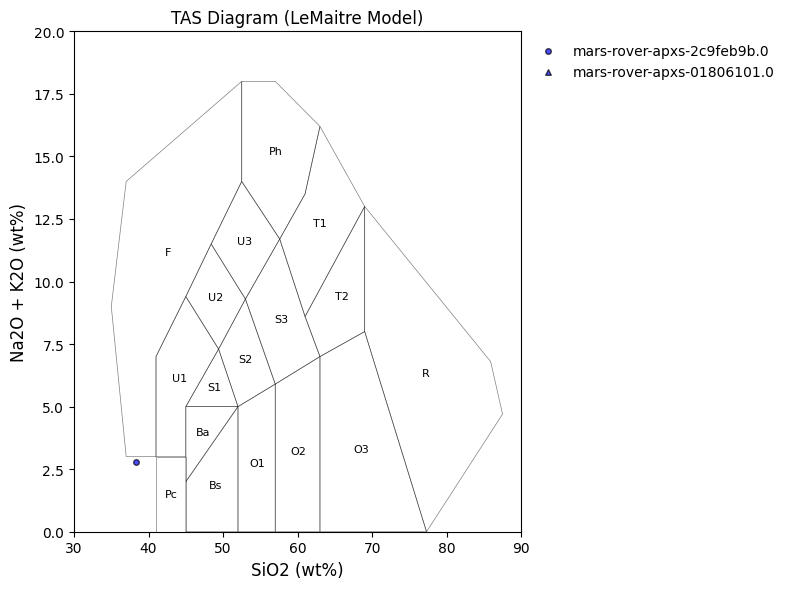

In [ ]:
# @title TAS Plotting Module

###############################################################################
# TAS Plots
###############################################################################

%matplotlib inline

import logging

# Set the logger for matplotlib.font_manager to ERROR (or higher) to hide the 'Arial' not found warnings
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

import io
import base64
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

try:
    from google.colab import files
    from google.colab import output
    colab_environment = True
except ImportError:
    files = None
    colab_environment = False

from pyrolite.util.classification import TAS

# Global variables to retain the most recent figure and DataFrame for downloading
last_fig = None
last_df = None

def classify_and_plot_all_data(
    df_list,
    si_col="SiO2",
    alk_col="Na2O + K2O",
    group_col="Group",
    which_model="LeMaitre"
):
    """
    Combines the list of DataFrames, applies TAS classification, and returns a plot
    and the combined classified DataFrame.
    """
    if not df_list:
        print("No data to plot.")
        return None, None

    df_all = pd.concat(df_list, ignore_index=True)

    cm = TAS(which_model=which_model)
    df_all["TAS_Field"] = cm.predict(df_all)
    df_all["Rocknames"] = df_all["TAS_Field"].apply(lambda x: cm.fields.get(x, {"name": None})["name"])

    fig, ax = plt.subplots(figsize=(8, 6))
    cm.add_to_axes(ax, alpha=0.5, linewidth=0.5, zorder=-1, add_labels=True)
    ax.set_xlabel(f"{si_col} (wt%)")
    ax.set_ylabel(f"{alk_col} (wt%)")
    ax.set_title(f"TAS Diagram ({which_model} Model)")

    unique_groups = df_all[group_col].unique()

    for grp in unique_groups:
        subset = df_all[df_all[group_col] == grp]
        color = subset["_style_color"].iloc[0] if "_style_color" in subset.columns else "blue"
        marker = subset["_style_marker"].iloc[0] if "_style_marker" in subset.columns else "o"
        ax.scatter(
            subset[si_col],
            subset[alk_col],
            color=color,
            marker=marker,
            edgecolors="k",
            alpha=0.7,
            label=grp
        )
    ax.legend()
    return fig, df_all

def fig_to_download_link(fig, filename="tas_plot.png"):
    """
    Convert a Matplotlib figure to a downloadable link (PNG).
    """
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=300)
    buf.seek(0)
    b64 = base64.b64encode(buf.read()).decode()
    return f'<a download="{filename}" href="data:image/png;base64,{b64}" target="_blank">Download Plot (.png)</a>'

def df_to_download_link(df, filename="tas_classification.csv"):
    """
    Convert a DataFrame to a downloadable CSV link.
    """
    csv_buf = io.StringIO()
    df.to_csv(csv_buf, index=False)
    b64 = base64.b64encode(csv_buf.getvalue().encode()).decode()
    return f'<a download="{filename}" href="data:text/csv;base64,{b64}" target="_blank">Download Classification (.csv)</a>'

# Add a new button for downloading CSV
download_csv_button = widgets.Button(
    description="Download CSV Classification",
    button_style="info"
)

def on_download_csv_button_clicked(_):
    global last_df
    from IPython.display import clear_output

    with plot_output_area:
        clear_output()
        if last_df is None:
            print("No classification data to download. Please generate it first.")
            return
        if not files:
            print("Cannot auto-download. Please run this in Google Colab or save manually.")
            return

        filename = "tas_classification.csv"
        last_df.to_csv(filename, index=False)
        print(f"Saved CSV as {filename} - initiating download...")
        files.download(filename)

###############################################################################
# Plotting UI
###############################################################################
plot_output_area = widgets.Output(layout={'border': '1px solid black'})
download_links_html = widgets.HTML(value="")

model_dropdown = widgets.Dropdown(
    options=["Middlemost", "LeMaitre", "LeMaitreCombined"],
    value="LeMaitre",
    description="TAS Model:"
)
plot_button = widgets.Button(description="Plot & Classify All", button_style="success")

image_format_dropdown = widgets.Dropdown(
    options=['png', 'pdf', 'svg', 'jpg'],
    value='png',
    description='Save As:'
)
download_plot_button = widgets.Button(description="Download TAS Plot", button_style="info")
clear_all_plots_button = widgets.Button(description="Clear All Plots", button_style="danger")

def on_plot_button_clicked(_):
    global last_fig, last_df
    from IPython.display import HTML
    with plot_output_area:
        clear_output()
        if not globals().get('datasets_storage'):
            print("No datasets found. Please run the first cell to add data.")
            return

        which_model = model_dropdown.value
        fig, df_classified = classify_and_plot_all_data(
            globals()['datasets_storage'],
            si_col="SiO2",
            alk_col="Na2O + K2O",
            group_col="Group",
            which_model=which_model
        )
        if fig is None or df_classified is None:
            return

        last_fig = fig
        last_df = df_classified

        # Create download links for the figure and CSV
        csv_dl = df_to_download_link(df_classified, filename="tas_classification.csv")
        download_links_html.value = f"<p>{csv_dl}</p>"

def on_download_plot_button_clicked(_):
    with plot_output_area:
        clear_output()
        global last_fig
        if last_fig is None:
            print("No plot to download. Please generate it first.")
            return

        fmt = image_format_dropdown.value
        if not files:
            print("Cannot auto-download. Please run this in Google Colab or save manually.")
            return

        filename = f"tas_plot.{fmt}"
        last_fig.savefig(filename, format=fmt, dpi=300)
        print(f"Saved plot as {filename} - initiating download...")
        files.download(filename)

def on_clear_all_plots_button_clicked(_):
    global last_fig
    plt.close('all')
    last_fig = None
    with plot_output_area:
        clear_output()
        download_links_html.value = ""
        print("All plots cleared.")
    if colab_environment:
        output.clear(wait=True)

plot_button.on_click(on_plot_button_clicked)
download_plot_button.on_click(on_download_plot_button_clicked)
clear_all_plots_button.on_click(on_clear_all_plots_button_clicked)
download_csv_button.on_click(on_download_csv_button_clicked)

plot_ui = widgets.VBox([
    widgets.HTML("<h3>Plotting & Download Module</h3>"),
    model_dropdown,
    plot_button,
    widgets.HTML("<hr><b>Download Output:</b>"),
    download_links_html,  # Existing HTML link (works in local Jupyter)
    widgets.HTML("<hr>"),

    widgets.HTML("<b>Select Format & Download Plot (Colab):</b>"),
    widgets.HBox([image_format_dropdown, download_plot_button]),

    widgets.HTML("<hr>"),
    download_csv_button,

    widgets.HTML("<hr>"),
    clear_all_plots_button,
    plot_output_area
])

display(plot_ui)

In [ ]:
# @title Ternary Diagram Plotter
import matplotlib.pyplot as plt
import io
import base64
import ipywidgets as widgets
from IPython.display import display, clear_output
from pyrolite.plot import pyroplot
import pandas as pd

# Global figure reference for downloads
tern_fig = None

# Define ternary plot options
ternary_plot_options = {
    "SiO2_MgO_FeO": {
        "cols": ["SiO2", "MgO", "FeO"],
        "alternatives": {
            "SiO2": ["SiO_2", "SiO2", "si", "sio2"],
            "MgO": ["MgO", "mgo"],
            "FeO": ["FeO", "feo"]
        },
        "title": "SiO₂ - MgO - FeO"
    },
    "SiO2_CaO_Al2O3": {
        "cols": ["SiO2", "CaO", "Al2O3"],
        "alternatives": {
            "SiO2": ["SiO_2", "SiO2", "si", "sio2"],
            "CaO": ["CaO", "cao"],
            "Al2O3": ["Al2O3", "al2o3"]
        },
        "title": "SiO₂ - CaO - Al₂O₃"
    },
    "SiO2_Na2O_K2O": {
        "cols": ["SiO2", "Na2O", "K2O"],
        "alternatives": {
            "SiO2": ["SiO_2", "SiO2", "si", "sio2"],
            "Na2O": ["Na2O", "na2o"],
            "K2O": ["K2O", "k2o"]
        },
        "title": "SiO₂ - Na₂O - K₂O"
    }
}

# Create UI elements
plot_checkboxes = [
    (key, widgets.Checkbox(value=False, description=info["title"]))
    for key, info in ternary_plot_options.items()
]

ternary_download_format_dropdown = widgets.Dropdown(
    options=["png", "jpg", "svg", "pdf"],
    value="png",
    description="Format:"
)

plot_ternary_button = widgets.Button(
    description="Create Ternary Plots",
    button_style="primary"
)

download_ternary_button = widgets.Button(
    description="Download Plot(s)",
    button_style="success"
)

ternary_plot_output = widgets.Output(layout={'border': '1px solid black', 'padding': '10px'})

def plot_ternary_diagrams(_):
    global tern_fig
    with ternary_plot_output:
        clear_output()

        selected_plots = [key for key, cb in plot_checkboxes if cb.value]
        if not selected_plots:
            print("Please select at least one diagram type.")
            return

        nplots = len(selected_plots)
        fig, axes = plt.subplots(1, nplots, figsize=(6*nplots, 5),
                                 subplot_kw={'projection': 'ternary'})
        if nplots == 1:
            axes = [axes]

        for ax, plot_key in zip(axes, selected_plots):
            plot_info = ternary_plot_options[plot_key]
            ax.set_title(plot_info["title"])

            for df in datasets_storage:
                for _, group_data in df.groupby('Group'):
                    # Set non-underscore label using a formatted string.
                    # Ensure the label is a meaningful, non-empty string.
                    group_label = group_data['Group'].iloc[0]
                    label = f"Group: {group_label}" if pd.notna(group_label) and group_label != "" else "Unknown Group"

                    color = group_data['_style_color'].iloc[0]
                    marker = group_data['_style_marker'].iloc[0]

                    # Get the required columns
                    cols = plot_info["cols"]
                    data = group_data[cols].copy()

                    # Normalize the data (optional)
                    data = data.div(data.sum(axis=1), axis=0) * 100

                    # Plot using pyrolite, explicitly passing a valid label.
                    data.pyroplot.scatter(ax=ax, c=color, marker=marker,
                                          label=label, alpha=0.7)
            # Force legend creation by extracting the handles and labels.
            handles, labels = ax.get_legend_handles_labels()
            if handles and labels:
                ax.legend(handles, labels, loc='upper left')
        plt.tight_layout()
        tern_fig = fig
        plt.show()

def download_plot(_):
    global tern_fig
    if tern_fig is None:
        print("Please create a plot first")
        return

    fmt = ternary_download_format_dropdown.value
    buf = io.BytesIO()
    tern_fig.savefig(buf, format=fmt, bbox_inches='tight')
    buf.seek(0)

    b64 = base64.b64encode(buf.read()).decode()
    filename = f"ternary_plots.{fmt}"
    href = f'data:image/{fmt};base64,{b64}'

    download_link = f'<a download="{filename}" href="{href}">Download {filename}</a>'
    display(widgets.HTML(download_link))

# Connect buttons to functions
plot_ternary_button.on_click(plot_ternary_diagrams)
download_ternary_button.on_click(download_plot)

# Create and display UI
checkboxes_box = widgets.VBox([cb for _, cb in plot_checkboxes])
ternary_ui = widgets.VBox([
    widgets.HTML("<h3>Ternary Diagram Plotting</h3>"),
    widgets.HTML("<b>Select Ternary Diagram(s):</b>"),
    checkboxes_box,
    widgets.HBox([plot_ternary_button, ternary_download_format_dropdown, download_ternary_button]),
    ternary_plot_output
])

display(ternary_ui)

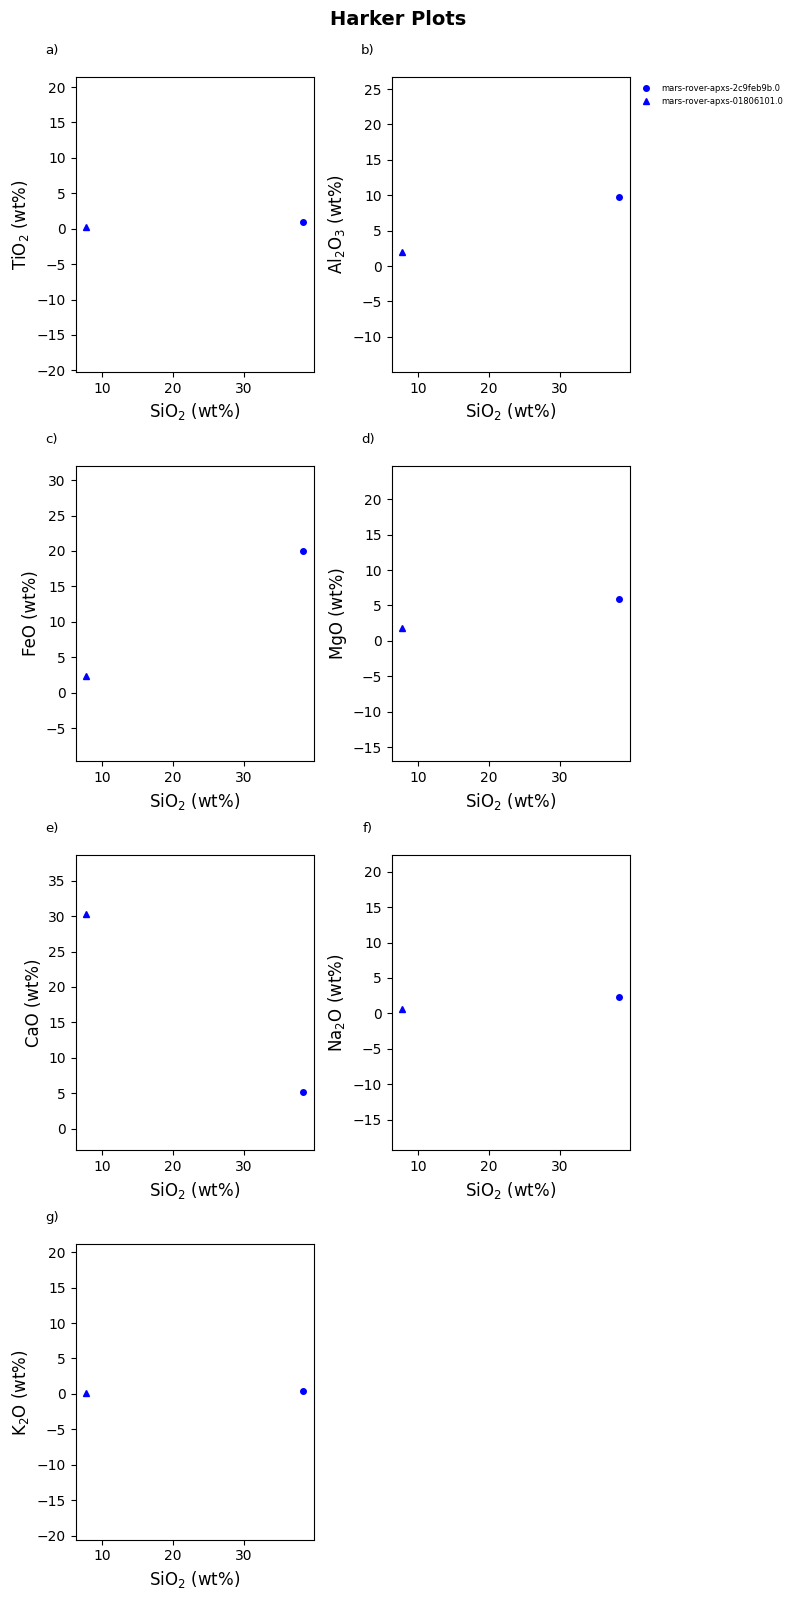

In [ ]:
# @title Harker Plotting Tool
import io
import base64
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

###############################################################################
# Environment detection for Google Colab
###############################################################################
try:
    from google.colab import files
    from google.colab import output
    colab_environment = True
except ImportError:
    files = None
    colab_environment = False

last_fig = None
last_df = None

###############################################################################
# ADD DATASET FUNCTION (for convenience)
###############################################################################
def add_dataset(df):
    global datasets_storage
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Please provide a pandas DataFrame.")
    datasets_storage.append(df)

###############################################################################
# MAIN HARKER PLOTTING FUNCTION
###############################################################################
def build_and_plot_harker(elements_list=None, output_filename="HarkerPlot"):
    """
    Build a Harker diagram from all DataFrames in 'datasets_storage'.

    Returns
    -------
    (fig, df_all): The created Figure and a concatenated DataFrame of all data.
    """

    global last_fig, last_df

    if not datasets_storage:
        print("No datasets found. Please add data to 'datasets_storage'.")
        return None, None

    # We only plot these 8 oxides:
    #   SiO2 (as X) for all subplots,
    #   TiO2, Al2O3, FeO, MgO, CaO, Na2O, K2O as Y.
    if not elements_list:
        elements_list = ["SiO2", "TiO2", "Al2O3", "FeO", "MgO", "CaO", "Na2O", "K2O"]

    # We will create 8 subplots in a 4x2 grid but only use the first 7.
    fig, axes = plt.subplots(4, 2)
    sub = axes.ravel()

    # 7 Y labels for these subplots:
    y_labels = [
        r"TiO$_2$ (wt%)",
        r"Al$_2$O$_3$ (wt%)",
        r"FeO (wt%)",
        r"MgO (wt%)",
        r"CaO (wt%)",
        r"Na$_2$O (wt%)",
        r"K$_2$O (wt%)"
    ]
    titles = ["a)", "b)", "c)", "d)", "e)", "f)", "g)"]

    plt.rcParams["font.family"] = "DejaVu Sans"
    plt.rcParams["font.size"] = 8

    # Plot each oxide in a separate subplot (indices 0..6), hide subplot 7.
    for s in range(7):
        y_name = elements_list[s + 1]

        for i, df in enumerate(datasets_storage):
            if elements_list[0] not in df.columns or y_name not in df.columns:
                continue

            x_vals = df[elements_list[0]].dropna()
            y_vals = df[y_name].dropna()

            min_len = min(len(x_vals), len(y_vals))
            x_vals = x_vals.iloc[:min_len]
            y_vals = y_vals.iloc[:min_len]

            # Default styles
            color_style = "black"
            marker_style = "o"

            # If any style column is found, use it
            if "_style_color" in df.columns and not df["_style_color"].dropna().empty:
                color_style = df["_style_color"].dropna().iloc[0]
            if "_style_marker" in df.columns and not df["_style_marker"].dropna().empty:
                marker_style = df["_style_marker"].dropna().iloc[0]

            # Use 'Group' column for labeling if present
            group_label = f"DataSet {i + 1}"
            if "Group" in df.columns:
                unique_groups = df["Group"].dropna().unique()
                if len(unique_groups) == 1:
                    group_label = unique_groups[0]
                elif len(unique_groups) > 1:
                    group_label = " & ".join(map(str, unique_groups))

            sub[s].plot(
                x_vals,
                y_vals,
                marker_style,
                markerfacecolor=color_style,
                markeredgecolor=color_style,
                markersize=4,
                label=group_label
            )

        sub[s].set_xlabel(r"SiO$_2$ (wt%)")
        sub[s].set_ylabel(y_labels[s])
        sub[s].set_title(titles[s], x=-0.1, y=1.05)

        # Only show legend in the top-right subplot (index=1)
        if s == 1:
            sub[s].legend(numpoints=1, fontsize=6)

        # Make axes square (adjusting for data limits).
        sub[s].relim()
        sub[s].autoscale_view()
        sub[s].set_aspect('equal', adjustable='datalim')

    # Hide the 8th subplot (index 7)
    sub[7].set_visible(False)

    # Add a main title across the top
    fig.suptitle("Harker Plots", fontsize=14, fontweight='bold', x=0.5, y=0.995)

    # Adjust figure size so each subplot is comfortably square.
    fig.set_size_inches(8, 16)
    plt.tight_layout()

    # Save the figure
    plt.savefig(output_filename + ".png", dpi=300, bbox_inches="tight", pad_inches=0.25)

    # Concatenate data into a single DataFrame for optional CSV export
    frames = []
    for df in datasets_storage:
        frames.append(df)
    df_all = pd.concat(frames, ignore_index=True)

    last_fig = fig
    last_df = df_all

    return fig, df_all

###############################################################################
# HELPER FUNCTIONS FOR DOWNLOAD
###############################################################################
def fig_to_download_link(fig, fmt="png", filename_prefix="harker_plot"):
    """
    Convert a Matplotlib figure to a downloadable link in a chosen format.
    For local usage, you can display the returned HTML link in a cell.
    """
    buf = io.BytesIO()
    filename = f"{filename_prefix}.{fmt}"
    fig.savefig(buf, format=fmt, dpi=300)
    buf.seek(0)
    b64 = base64.b64encode(buf.read()).decode()
    if fmt.lower() in ["png", "jpg", "jpeg", "svg"]:
        mime_prefix = f"data:image/{fmt}"
    else:
        mime_prefix = f"data:application/{fmt}"
    return f'<a download="{filename}" href="{mime_prefix};base64,{b64}" target="_blank">Download Plot (.{fmt})</a>'

def df_to_download_link(df, filename="harker_data.csv"):
    """
    Convert a DataFrame to a downloadable CSV link.
    """
    csv_buf = io.StringIO()
    df.to_csv(csv_buf, index=False)
    b64 = base64.b64encode(csv_buf.getvalue().encode()).decode()
    return f'<a download="{filename}" href="data:text/csv;base64,{b64}" target="_blank">Download Data (.csv)</a>'

###############################################################################
# UI WIDGETS TO PLOT AND DOWNLOAD
###############################################################################
plot_output_area = widgets.Output(layout={"border": "1px solid black"})
download_links_html = widgets.HTML(value="")

plot_button = widgets.Button(description="Plot All Harker", button_style="success")
image_format_dropdown = widgets.Dropdown(
    options=["png", "pdf", "svg", "jpg"],
    value="png",
    description="Save As:"
)
download_plot_button = widgets.Button(description="Download Harker Plot", button_style="info")
clear_all_plots_button = widgets.Button(description="Clear All Plots", button_style="danger")

def on_plot_button_clicked(_):
    global last_fig, last_df
    with plot_output_area:
        clear_output()
        fig, df_data = build_and_plot_harker()
        if fig is None or df_data is None:
            return
        csv_dl_link = df_to_download_link(df_data, filename="harker_data.csv")
        download_links_html.value = f"<p>{csv_dl_link}</p>"

def on_download_plot_button_clicked(_):
    global last_fig
    with plot_output_area:
        clear_output()
        if last_fig is None:
            print("No plot to download. Please generate it first.")
            return
        fmt = image_format_dropdown.value
        # If in Colab, attempt direct download
        if colab_environment and files:
            filename = f"harker_plot.{fmt}"
            last_fig.savefig(filename, format=fmt, dpi=300)
            print(f"Saved plot as {filename}. Initiating download (Colab only)...")
            files.download(filename)
        else:
            # Provide an HTML link
            link = fig_to_download_link(last_fig, fmt=fmt, filename_prefix="harker_plot")
            download_links_html.value = link

def on_clear_all_plots_button_clicked(_):
    global last_fig
    plt.close("all")
    last_fig = None
    with plot_output_area:
        clear_output()
    download_links_html.value = ""
    if colab_environment:
        output.clear(wait=True)

plot_button.on_click(on_plot_button_clicked)
download_plot_button.on_click(on_download_plot_button_clicked)
clear_all_plots_button.on_click(on_clear_all_plots_button_clicked)

plot_ui = widgets.VBox([
    widgets.HTML("<h3>Harker Plotting & Download Module</h3>"),
    plot_button,
    widgets.HTML("<hr><b>Download Output:</b>"),
    download_links_html,
    widgets.HTML("<hr>"),
    widgets.HTML("<b>Select Format & Download Plot:</b>"),
    widgets.HBox([image_format_dropdown, download_plot_button]),
    widgets.HTML("<hr>"),
    clear_all_plots_button,
    plot_output_area
])

def display_harker_ui():
    """
    Display the Harker plotting UI.
    """
    display(plot_ui)

plot_button.on_click(on_plot_button_clicked)
download_plot_button.on_click(on_download_plot_button_clicked)
clear_all_plots_button.on_click(on_clear_all_plots_button_clicked)

# Build the UI
plot_ui = widgets.VBox([
    widgets.HTML("<h3>Harker Plotting & Download Module</h3>"),
    plot_button,
    widgets.HTML("<hr><b>Download Output:</b>"),
    download_links_html,
    widgets.HTML("<hr>"),
    widgets.HTML("<b>Select Format & Download Plot:</b>"),
    widgets.HBox([image_format_dropdown, download_plot_button]),
    widgets.HTML("<hr>"),
    clear_all_plots_button,
    plot_output_area
])

def display_harker_ui():
    """
    Call this function in your notebook to display the Harker plotting UI.
    """
    display(plot_ui)

display_harker_ui()

In [ ]:
# @title Weathering and Alteration Plotting Module

###############################################################################
#
# Weathering and Alteration
#
###############################################################################

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.stats import t

import pyrolite.geochem.alteration as pgi
from pyrolite.geochem.alteration import CIA, CIW, SAR, SiTiIndex, PIA, IshikawaAltIndex

# If running in Google Colab, import for direct file download
try:
    from google.colab import files
except ImportError:
    files = None

###############################################################################
# Helper Functions for Weathering/Alteration Indices and Statistics
###############################################################################

import re
from types import SimpleNamespace

def standardize_name(name):
    """
    Remove HTML tags (e.g., <sub>...</sub>) from a string.
    For example, "Al<sub>2</sub>O<sub>3</sub>" becomes "Al2O3".
    """
    return re.sub(r'<[^>]+>', '', name)

def compute_index(df, index_type):
    """
    Compute the specified weathering/alteration index for the DataFrame using pyrolite.
    Uses the oxide column names saved in df.attrs["detected_oxides"].
    For the Ishikawa alteration index, the entire DataFrame is passed directly.
    """
    # Work on a copy to avoid modifying original data
    df = df.copy()

    # Standardize all column names by removing HTML tags.
    df.columns = [standardize_name(col) for col in df.columns]

    # Update mapping from df.attrs with standardized names.
    mapping = df.attrs.get("detected_oxides", {})
    mapping = {key: standardize_name(val) for key, val in mapping.items()}

    # For Ishikawa, pass the unmodified DataFrame (now with standardized columns)
    if index_type == "Ishikawa":
        return IshikawaAltIndex(df)

    # Get oxide column names using the updated mapping.
    Al2O3_col = mapping.get("Al2O3", "Al2O3")
    CaO_col   = mapping.get("CaO", "CaO")
    Na2O_col  = mapping.get("Na2O", "Na2O")
    K2O_col   = mapping.get("K2O", "K2O")
    SiO2_col  = mapping.get("SiO2", "SiO2")
    TiO2_col  = mapping.get("TiO2", "TiO2")
    MgO_col   = mapping.get("MgO", "MgO")

    def compute_row(row):
        # Build a dictionary of oxides from the row
        oxides = {
            'Al2O3': row[Al2O3_col],
            'CaO':   row[CaO_col],
            'Na2O':  row[Na2O_col],
            'K2O':   row[K2O_col],
            'SiO2':  row[SiO2_col],
            'TiO2':  row[TiO2_col],
            'MgO':   row[MgO_col] if MgO_col in row.index else np.nan
        }
        # Convert the dictionary to an object with attribute access
        ox = SimpleNamespace(**oxides)

        # Use pyrolite functions for known indices if available.
        if index_type == "CIA":
            # CIA = [Al2O3 / (Al2O3 + CaO* + Na2O + K2O)] * 100
            return CIA(ox)
        elif index_type == "CIW":
            # CIW = [Al2O3 / (Al2O3 + CaO* + Na2O)] * 100
            return CIW(ox)
        elif index_type == "SAR":
            # SAR = SiO2 / Al2O3
            try:
                return SAR(ox)
            except ZeroDivisionError:
                return np.nan
        elif index_type == "SiTi":
            # SiTi = SiO2 / TiO2
            try:
                return SiTiIndex(ox)
            except ZeroDivisionError:
                return np.nan
        elif index_type == "PIA":
            # PIA = [(Al2O3 - K2O) / (Al2O3 + CaO* + Na2O - K2O)] * 100
            return PIA(ox)
        elif index_type == "WIP":
            # WIP calculation
            denominator = row[Na2O_col] + row[K2O_col] + row[CaO_col] + row[MgO_col] + row[Al2O3_col]
            if denominator == 0:
                return np.nan
            return ((row[Na2O_col] + row[K2O_col] + row[CaO_col] + row[MgO_col]) / denominator) * 100
        else:
            raise ValueError("Unknown index type: " + index_type)

    # Apply the compute_row function row-wise and return a Series
    return df.apply(compute_row, axis=1)

def assign_category(index_type, mean_val):
    """
    Assign a Category based on the mean index value (per group),
    using interpretations from the literature (e.g., Aye et al., 2021).
    For WIP, lower values indicate extensive weathering (loss of mobile cations),
    while higher values suggest minimal weathering.
    """
    if index_type == "CIA":
        if mean_val < 50:
            return "Fresh"
        elif mean_val >= 75:
            return "Intensely Weathered"
        else:
            return "Moderately Weathered"
    elif index_type == "CIW":
        if mean_val >= 80:
            return "Advanced Weathering"
        else:
            return "Fresh"
    elif index_type == "SAR":
        if mean_val < 3:
            return "Intense Weathering"
        elif mean_val > 6:
            return "Silica-rich"
        else:
            return "Moderate"
    elif index_type == "SiTi":
        if mean_val > 100:
            return "Minimal Alteration"
        elif mean_val < 20:
            return "Significant Silica Leaching"
        else:
            return "Moderate Alteration"
    elif index_type == "PIA":
        if mean_val > 75:
            return "High Plagioclase Alteration"
        else:
            return "Low/Moderate Plagioclase Alteration"
    elif index_type == "WIP":
        if mean_val > 50:
            return "Extensively Weathered"
        elif mean_val > 20:
            return "Moderately Weathered"
        else:
            return "Minimally Weathered"
    elif index_type == "Ishikawa":
        if mean_val > 60:
            return "Intense Alteration"
        elif mean_val > 40:
            return "Moderate Alteration"
        else:
            return "Low Alteration"
    else:
        return "Unknown"

# Options for indices
indices_options = [
    ("CIA (Sed. - Shales & fine-grained sediments | CaO partitioning needed)", "CIA"),
    ("CIW (Sed. - Shales/mudstones | Silicate weathering - aqueous)", "CIW"),
    ("SAR (Ig./Sed./Met. - Versatile | Compares silica and alumina to identify weathering processes)", "SAR"),
    ("SiTi (Volcanic & metamorphic rocks | Alteration to secondary minerals)", "SiTi"),
    ("PIA (Rocks with plagioclase | Plagioclase weathering and alteration)", "PIA"),
    ("WIP (Ig./Met. - Silicate rocks | Silicate chemical weathering)", "WIP"),
    ("Ishikawa (Vol. - Volcanic rocks | Hydrothermal Alteration)", "Ishikawa")
]

# Update the indices_select widget to use the new options.
indices_select = widgets.SelectMultiple(
    options=indices_options,
    value=["CIW"],
    description="Indices:",
    layout=widgets.Layout(width="auto"),
    rows=7
)

# Dropdown to select image format
image_format_dropdown = widgets.Dropdown(
    options=['png', 'pdf', 'svg', 'jpg'],
    value='png',
    description='Save As:'
)

plot_indices_button = widgets.Button(description="Plot Selected Indices", button_style="success")
export_indices_button = widgets.Button(description="Export Stats to CSV", button_style="warning")
download_plot_button = widgets.Button(description="Download Plot(s)", button_style="info")
indices_output_area = widgets.Output(layout={'border': '1px solid black'})

# Global storage for statistics and figures
indices_stats_storage = pd.DataFrame()
generated_figures = []

# Baseline values for hypothesis testing (from literature)
baseline_dict = {
    "CIA": 50,     # Below 50 indicates fresh rock
    "CIW": 80,     # CIW >=80 indicates advanced weathering
    "SAR": 3,      # SAR < 3 indicates intense weathering
    "SiTi": 20,    # SiTi < 20 indicates significant silica leaching
    "PIA": 75,     # PIA >75 indicates intense plagioclase alteration
    "WIP": 75,     # WIP >50 indicates low weathering, <20 high weathering
    "Ishikawa": 50
}

def on_plot_indices_button_clicked(_):
    global indices_stats_storage, generated_figures
    generated_figures.clear()

    with indices_output_area:
        clear_output()

        # Explicitly check for datasets and handle them safely
        datasets = globals().get("datasets_storage", [])
        if not datasets:
            print("No datasets available. Please add data first.")
            return

        df_all = pd.concat(datasets, ignore_index=True)

        group_col = "Group"
        groups = df_all[group_col].unique()

        stats_records = []
        group_values = {}
        group_labels = []
        group_colors = {}
        group_markers = {}

        for index_type in indices_select.value:
            group_values[index_type] = {}
            for grp in groups:
                group_values[index_type][grp] = []

        for grp in groups:
            grp_mask = (df_all[group_col] == grp)
            color = df_all[grp_mask]["_style_color"].iloc[0] if "_style_color" in df_all.columns else "blue"
            marker = df_all[grp_mask]["_style_marker"].iloc[0] if "_style_marker" in df_all.columns else "o"
            group_colors[grp] = color
            group_markers[grp] = marker
            group_labels.append(grp)

        for index_type in indices_select.value:
            try:
                index_series = compute_index(df_all, index_type)
            except Exception as e:
                print(f"Error computing {index_type}: {e}")
                continue

            for grp in groups:
                grp_mask = (df_all[group_col] == grp)
                vals = index_series[grp_mask].dropna()
                if not vals.empty:
                    group_mean = vals.mean()
                    group_std = vals.std(ddof=1)
                    group_count = vals.count()
                    group_cat = assign_category(index_type, group_mean)

                    df_ = group_count - 1
                    if df_ >= 1:
                        sem = group_std / np.sqrt(group_count)
                        if np.isclose(sem, 0):
                            ci95_low = group_mean
                            ci95_high = group_mean
                            p_value = 1.0
                            significance = ""
                        else:
                            alpha_95 = 0.05
                            t_crit_95 = t.ppf(1 - alpha_95/2, df_)
                            margin_of_error_95 = sem * t_crit_95
                            ci95_low = group_mean - margin_of_error_95
                            ci95_high = group_mean + margin_of_error_95

                            baseline = baseline_dict.get(index_type, 0)
                            t_stat = (group_mean - baseline) / sem
                            p_value = 2 * (1 - t.cdf(abs(t_stat), df_))
                            if p_value < 0.01:
                                significance = "**"
                            elif p_value < 0.05:
                                significance = "*"
                            else:
                                significance = ""
                    else:
                        ci95_low, ci95_high = np.nan, np.nan
                        p_value = np.nan
                        significance = ""

                    stats_records.append({
                        "Index": index_type,
                        "Group": grp,
                        "Mean": group_mean,
                        "StdDev": group_std,
                        "Count": group_count,
                        "Category": group_cat,
                        "CI95_Lower": ci95_low,
                        "CI95_Upper": ci95_high,
                        "p_value": p_value,
                        "Significance": significance,
                        "Baseline": baseline_dict.get(index_type, np.nan)
                    })
                    group_values[index_type][grp] = vals.values

        for index_type in indices_select.value:
            data_for_plot = []
            valid_labels = []
            for grp in group_labels:
                vals = group_values[index_type][grp]
                if len(vals) > 0:
                    data_for_plot.append(vals)
                    valid_labels.append(grp)

            if data_for_plot:
                fig, ax = plt.subplots(figsize=(8, 6))
                # Pass valid_labels as the labels for the boxplot
                bp = ax.boxplot(data_for_plot, labels=valid_labels, patch_artist=True)
                ax.set_title(f"{index_type} by Group")
                ax.set_ylabel(index_type)
                ax.set_xlabel("Group")
                for element in ["boxes", "whiskers", "caps", "medians", "fliers"]:
                    plt.setp(bp[element], alpha=0.4)
                y_top = ax.get_ylim()[1] * 0.9
                for i, grp in enumerate(group_labels):
                    matching = [rec for rec in stats_records if rec["Index"] == index_type and rec["Group"] == grp]
                    if matching:
                        rec = matching[0]
                        m = rec["Mean"]
                        ci_low95 = rec["CI95_Lower"]
                        ci_high95 = rec["CI95_Upper"]
                        cat = rec["Category"]
                        significance = rec["Significance"]
                        label_text = (
                            f"Mean={m:.2f}\n"
                            f"95%CI=[{ci_low95:.2f}, {ci_high95:.2f}]\n"
                            f"Cat={cat}{significance}"
                        )
                        ax.text(
                            i + 1,
                            y_top,
                            label_text,
                            fontsize=9,
                            ha="center",
                            va="top",
                            bbox=dict(facecolor="white", alpha=0.6, edgecolor="black"),
                        )
                for i, grp in enumerate(group_labels):
                    vals = group_values[index_type][grp]
                    if len(vals):
                        x_jitter = np.random.normal(i + 1, 0.04, size=len(vals))
                        ax.scatter(
                            x_jitter,
                            vals,
                            color=group_colors[grp],
                            marker=group_markers[grp],
                            edgecolors="k",
                            alpha=0.7,
                            s=20
                        )
                plt.tight_layout()
                plt.show()
                generated_figures.append(fig)

        indices_stats_storage = pd.DataFrame(stats_records) if stats_records else pd.DataFrame()

def on_export_indices_button_clicked(_):
    with indices_output_area:
        clear_output()
        global indices_stats_storage
        if indices_stats_storage.empty:
            print("No stats to export. Please run a plot first.")
            return

        # Write CSV content to a file and trigger download in Colab.
        csv_buffer = indices_stats_storage.to_csv(index=False)
        filename = "weathering_stats.csv"
        with open(filename, "w") as f:
            f.write(csv_buffer)
        if files:
            files.download(filename)
        else:
            print("CSV file generated:")
            print(csv_buffer)

def on_download_plot_button_clicked(_):
    with indices_output_area:
        clear_output()
        global generated_figures
        if not generated_figures:
            print("No plots to download. Please generate a plot first.")
            return
        fmt = image_format_dropdown.value
        if not files:
            print("Cannot auto-download. Please run this in Google Colab or save manually.")
            return
        for idx, fig in enumerate(generated_figures, start=1):
            filename = f"weathering_plot_{idx}.{fmt}"
            fig.savefig(filename, format=fmt, dpi=300)
            print(f"Saved plot #{idx} as {filename} - initiating download...")
            files.download(filename)
        print("\nAll requested plots have been downloaded (Colab).")

plot_indices_button.on_click(on_plot_indices_button_clicked)
export_indices_button.on_click(on_export_indices_button_clicked)
download_plot_button.on_click(on_download_plot_button_clicked)

indices_ui = widgets.VBox([
    widgets.HTML("<h3>Weathering & Alteration Indices Plots</h3>"),
    widgets.HTML("Select one or more indices to plot:"),
    indices_select,
    widgets.HBox([plot_indices_button, export_indices_button]),
    widgets.HTML("<hr>"),
    widgets.HTML("<b>Select Format & Download Plots:</b>"),
    widgets.HBox([image_format_dropdown, download_plot_button]),
    indices_output_area
])

display(indices_ui)

In [ ]:
# @title LLOD Plotting Module
import pyrolite.geochem.magma as magma
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import io
import base64

###############################################################################
# Example datasets storage list (similar approach as in the example code)
###############################################################################
# Please ensure you have a global list called datasets_storage which holds
# all your DataFrames to be plotted. For instance:
#
# datasets_storage = []
# def add_dataset(df):
#     if not isinstance(df, pd.DataFrame):
#         raise ValueError("Please provide a pandas DataFrame.")
#     datasets_storage.append(df)
#
###############################################################################

# A dedicated output area for the plotting interface
magma_plot_output = widgets.Output(layout={'border': '1px solid black', 'padding': '10px'})

# Dropdown to select the plot type
plot_type_dropdown = widgets.Dropdown(
    options=[
        ("Both FeAt8MgO & NaAt8MgO", "both"),
        ("FeAt8MgO vs. MgO only", "fe"),
        ("NaAt8MgO vs. MgO only", "na")
    ],
    value="both",
    description="Plot Type:"
)

# Dropdown to select download format
download_format_dropdown = widgets.Dropdown(
    options=["png", "jpg", "svg", "pdf"],
    value="png",
    description="Format:"
)

# Button to trigger the plotting
plot_button = widgets.Button(
    description="Plot",
    button_style="primary"
)

# Button to download the plot
download_plot_button = widgets.Button(
    description="Download Plot",
    button_style="success"
)

# Hold the current figure globally, so it can be downloaded
magma_fig = None

def on_plot_button_clicked(_):
    """
    Creates the requested plot(s) based on the selected plot type from plot_type_dropdown.
    Plots data from all DataFrames stored in datasets_storage, labeling them by group if multiple
    subgroups (e.g. libs-4A1-2, libs-4A1-3, etc.) exist in a single DataFrame.

    Incorporates fallback logic to handle potential mismatches between the 'detected_oxides'
    dictionary and the actual DataFrame columns.
    """
    global magma_fig
    with magma_plot_output:
        clear_output()

        if not datasets_storage:
            print("No datasets available to plot. Please add CSV or simulated data first.")
            return

        plot_mode = plot_type_dropdown.value

        # Decide on figure layout
        if plot_mode == "both":
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            ax1.set_title("FeAt8MgO vs. MgO")
            ax2.set_title("NaAt8MgO vs. MgO")
            ax1.set_xlabel("MgO (wt%)")
            ax2.set_xlabel("MgO (wt%)")
            ax1.set_ylabel("FeAt8MgO (wt%)")
            ax2.set_ylabel("NaAt8MgO (wt%)")
        else:
            fig, ax = plt.subplots(1, 1, figsize=(6, 5))
            if plot_mode == "fe":
                ax.set_title("FeAt8MgO vs. MgO")
                ax.set_xlabel("MgO (wt%)")
                ax.set_ylabel("FeAt8MgO (wt%)")
            else:  # "na"
                ax.set_title("NaAt8MgO vs. MgO")
                ax.set_xlabel("MgO (wt%)")
                ax.set_ylabel("NaAt8MgO (wt%)")

        # Plot each DataFrame
        for i, df in enumerate(datasets_storage):
            # If "Group" exists, plot each group separately
            if "Group" in df.columns:
                unique_groups = df["Group"].dropna().unique()
                if len(unique_groups) == 0:
                    # If no valid group entries, treat entire DF as one group
                    unique_groups = [None]
            else:
                # If no "Group" column, treat entire DF as one group
                unique_groups = [None]

            for grp_name in unique_groups:
                if grp_name is not None:
                    sub = df[df["Group"] == grp_name]
                else:
                    sub = df

                # The dictionary that might map oxide names to actual column names
                oxides = sub.attrs.get("detected_oxides", {})

                # Attempt dictionary lookup for FeO and MgO
                fe_candidate = oxides.get("FeO", None)
                mg_candidate = oxides.get("MgO", None)

                # Fallback if the referenced dictionary columns aren't in sub
                if fe_candidate not in sub.columns and "FeO" in sub.columns:
                    fe_candidate = "FeO"
                if mg_candidate not in sub.columns and "MgO" in sub.columns:
                    mg_candidate = "MgO"

                fe_col = fe_candidate if fe_candidate in sub.columns else None
                mg_col = mg_candidate if mg_candidate in sub.columns else None

                # Handle Na2O with dictionary references + fallback
                na_candidates = []
                if "Na2O" in oxides:
                    na_candidates.append(oxides["Na2O"])
                if "Na<sub>2</sub>O" in oxides:
                    na_candidates.append(oxides["Na<sub>2</sub>O"])

                na_col = None
                for candidate in na_candidates:
                    if candidate in sub.columns:
                        na_col = candidate
                        break

                # Final fallback if none of those dictionary references worked
                if na_col is None and "Na2O" in sub.columns:
                    na_col = "Na2O"

                # Determine style color/marker
                color_style = "blue"
                marker_style = "o"
                if "_style_color" in sub.columns and not sub["_style_color"].dropna().empty:
                    color_style = sub["_style_color"].dropna().iloc[0]
                if "_style_marker" in sub.columns and not sub["_style_marker"].dropna().empty:
                    marker_style = sub["_style_marker"].dropna().iloc[0]

                # Group label
                if grp_name is not None:
                    group_label = str(grp_name)
                else:
                    group_label = f"Dataset {i + 1}"

                # Plot according to selected mode
                if plot_mode == "both":
                    # FeAt8MgO
                    if fe_col and mg_col:
                        fe_vals = sub[fe_col].dropna()
                        mg_vals = sub[mg_col].dropna()
                        min_len = min(len(fe_vals), len(mg_vals))
                        fe_vals = fe_vals.iloc[:min_len]
                        mg_vals = mg_vals.iloc[:min_len]

                        fe_8 = magma.FeAt8MgO(fe_vals, mg_vals)
                        ax1.scatter(mg_vals, fe_8, color=color_style, marker=marker_style,
                                    alpha=0.7, label=group_label)
                    else:
                        print(f"Skipping FeAt8MgO for {group_label} (FeO or MgO missing)")

                    # NaAt8MgO
                    if na_col and mg_col:
                        na_vals = sub[na_col].dropna()
                        mg_vals_2 = sub[mg_col].dropna()
                        min_len2 = min(len(na_vals), len(mg_vals_2))
                        na_vals = na_vals.iloc[:min_len2]
                        mg_vals_2 = mg_vals_2.iloc[:min_len2]

                        na_8 = magma.NaAt8MgO(na_vals, mg_vals_2)
                        ax2.scatter(mg_vals_2, na_8, color=color_style, marker=marker_style,
                                    alpha=0.7, label=group_label)
                    else:
                        print(f"Skipping NaAt8MgO for {group_label} (Na2O or MgO missing)")

                elif plot_mode == "fe":
                    if fe_col and mg_col:
                        fe_vals = sub[fe_col].dropna()
                        mg_vals = sub[mg_col].dropna()
                        min_len = min(len(fe_vals), len(mg_vals))
                        fe_vals = fe_vals.iloc[:min_len]
                        mg_vals = mg_vals.iloc[:min_len]

                        fe_8 = magma.FeAt8MgO(fe_vals, mg_vals)
                        ax.scatter(mg_vals, fe_8, color=color_style, marker=marker_style,
                                   alpha=0.7, label=group_label)
                    else:
                        print(f"Skipping FeAt8MgO for {group_label} (FeO or MgO missing)")

                else:  # "na"
                    if na_col and mg_col:
                        na_vals = sub[na_col].dropna()
                        mg_vals = sub[mg_col].dropna()
                        min_len = min(len(na_vals), len(mg_vals))
                        na_vals = na_vals.iloc[:min_len]
                        mg_vals = mg_vals.iloc[:min_len]

                        na_8 = magma.NaAt8MgO(na_vals, mg_vals)
                        ax.scatter(mg_vals, na_8, color=color_style, marker=marker_style,
                                   alpha=0.7, label=group_label)
                    else:
                        print(f"Skipping NaAt8MgO for {group_label} (Na2O or MgO missing)")

        # Finalize legends
        if plot_mode == "both":
            handles1, labels1 = ax1.get_legend_handles_labels()
            handles2, labels2 = ax2.get_legend_handles_labels()
            # Deduplicate labels
            combined_1 = dict(zip(labels1, handles1))
            combined_2 = dict(zip(labels2, handles2))
            ax1.legend(combined_1.values(), combined_1.keys(), loc="best", fontsize="small")
            ax2.legend(combined_2.values(), combined_2.keys(), loc="best", fontsize="small")
        else:
            handles, labels = ax.get_legend_handles_labels()
            combined = dict(zip(labels, handles))
            ax.legend(combined.values(), combined.keys(), loc="best", fontsize="small")

        plt.tight_layout()
        plt.show()

        magma_fig = fig

def on_download_plot_button_clicked(_):
    """
    Immediately downloads the currently displayed figure in the selected format.
    If no figure is available, it notifies the user.
    """
    global magma_fig
    with magma_plot_output:
        clear_output()
        if magma_fig is None:
            print("No plot to download. Please generate a plot first.")
            return

        fmt = download_format_dropdown.value
        # Save the figure to an in-memory buffer
        buf = io.BytesIO()
        magma_fig.savefig(buf, format=fmt, bbox_inches="tight", dpi=300)
        buf.seek(0)

        # Convert to base64
        b64 = base64.b64encode(buf.read()).decode()

        # Create an HTML link for downloading
        download_filename = f"magma_plots.{fmt}"
        payload = f"data:image/{fmt};base64,{b64}"

        html_link = (
            f'<a download="{download_filename}" href="{payload}" '
            f'target="_blank" rel="noopener noreferrer">Download {download_filename}</a>'
        )

        display(widgets.HTML(html_link))

        # Auto-click for immediate download
        auto_click_js = f"""
        <script>
        var link = document.createElement('a');
        link.href = "{payload}";
        link.download = "{download_filename}";
        document.body.appendChild(link);
        link.click();
        document.body.removeChild(link);
        </script>
        """
        display(widgets.HTML(auto_click_js))

plot_button.on_click(on_plot_button_clicked)
download_plot_button.on_click(on_download_plot_button_clicked)

magma_plot_ui = widgets.VBox([
    widgets.HTML("<h3>LLOD Plot Module</h3>"),
    plot_type_dropdown,
    widgets.HBox([plot_button, download_format_dropdown, download_plot_button]),
    magma_plot_output
])

display(magma_plot_ui)

In [ ]:
# @title Clustering and PCA Analysis Module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import re

try:
    from tqdm.notebook import tqdm
    has_tqdm = True
except ImportError:
    has_tqdm = False

try:
    from cuml.cluster import KMeans as cuKMeans
    from cuml.decomposition import PCA as cuPCA
    from cuml.metrics import silhouette_score as cu_silhouette_score
    from cuml.preprocessing import StandardScaler as cuStandardScaler
    gpu_available = True
    print("GPU acceleration is available.")
except ImportError:
    gpu_available = False
    print("GPU acceleration not available.")

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler

output_area = widgets.Output(layout={'border': '1px solid black'})

outlier_check = widgets.Checkbox(value=False, description="Remove Outliers?")
z_thresh = widgets.FloatText(value=3.0, description="Z-thr:")
log_check = widgets.Checkbox(value=True, description="Log?")
method_dropdown = widgets.Dropdown(
    options=[
        ("Auto (best)", "auto"),
        ("KMeans", "kmeans"),
        ("Agglomerative", "agglomerative"),
        ("GMM", "gmm")
    ],
    value="gmm",
    description="Method:"
)
auto_k = widgets.Checkbox(value=True, description="Auto k?")
max_k = widgets.IntSlider(value=10, min=3, max=20, step=1, description="Max k:", continuous_update=False)
manual_k = widgets.IntSlider(value=3, min=2, max=20, step=1, description="k:", continuous_update=False)
reruns = widgets.IntSlider(value=5, min=1, max=250, step=1, description="Repeats:", continuous_update=False)
run_btn = widgets.Button(description="Run", button_style="primary")

def remove_outliers_by_zscore(df, thr=3.0):
    from scipy.stats import zscore
    cols = df.select_dtypes(include=[np.number]).columns
    z = np.abs(zscore(df[cols], nan_policy='omit'))
    return df[(z <= thr).all(axis=1)].reset_index(drop=True)

def auto_select_k_kmeans(data, kmin=2, kmax=10, ninit=5):
    best_k, best_score = kmin, -1
    scores_dict = {}
    ks = range(kmin, kmax + 1)
    if has_tqdm: ks = tqdm(ks, desc="KMeans")
    for k in ks:
        best_s = -1
        for _ in range(ninit):
            if gpu_available:
                km = cuKMeans(n_clusters=k, n_init=1)
                labels = km.fit_predict(data)
                s = cu_silhouette_score(data, labels)
            else:
                km = KMeans(n_clusters=k, n_init=1)
                labels = km.fit_predict(data)
                s = silhouette_score(data, labels)
            if s > best_s:
                best_s = s
        scores_dict[k] = best_s
        if best_s > best_score:
            best_score = best_s
            best_k = k
    return best_k, best_score, scores_dict

def auto_select_k_agglomerative(data, kmin=2, kmax=10):
    best_k, best_score = kmin, -1
    scores_dict = {}
    ks = range(kmin, kmax + 1)
    if has_tqdm: ks = tqdm(ks, desc="Agglomerative")
    for k in ks:
        a = AgglomerativeClustering(n_clusters=k)
        labels = a.fit_predict(data)
        s = silhouette_score(data, labels) if len(np.unique(labels)) > 1 else -1
        scores_dict[k] = s
        if s > best_score:
            best_score = s
            best_k = k
    return best_k, best_score, scores_dict

def auto_select_k_gmm(data, kmin=2, kmax=10, ninit=5):
    best_k, best_score = kmin, -1
    scores_dict = {}
    ks = range(kmin, kmax + 1)
    if has_tqdm: ks = tqdm(ks, desc="GMM")
    for k in ks:
        best_s = -1
        for _ in range(ninit):
            gm = GaussianMixture(n_components=k, n_init=1)
            labels = gm.fit_predict(data)
            s = silhouette_score(data, labels) if len(np.unique(labels)) > 1 else -1
            if s > best_s:
                best_s = s
        scores_dict[k] = best_s
        if best_s > best_score:
            best_score = best_s
            best_k = k
    return best_k, best_score, scores_dict

def auto_select_best_method(data, kmin=2, kmax=10, ninit=5):
    methods = ["kmeans", "agglomerative", "gmm"]
    overall_best = {"method": None, "k": None, "score": -1}
    for m in methods:
        if m == "kmeans":
            bk, bs, _ = auto_select_k_kmeans(data, kmin, kmax, ninit)
        elif m == "agglomerative":
            bk, bs, _ = auto_select_k_agglomerative(data, kmin, kmax)
        else:
            bk, bs, _ = auto_select_k_gmm(data, kmin, kmax, ninit)
        if bs > overall_best["score"]:
            overall_best = {"method": m, "k": bk, "score": bs}
    return overall_best

def on_run_btn_clicked(_):
    with output_area:
        clear_output()
        if 'libs_data' in globals():
            df_orig = globals()['libs_data']
        elif 'datasets_storage' in globals() and len(datasets_storage) > 0:
            df_orig = pd.concat(datasets_storage, ignore_index=True)
        else:
            print("No data available.")
            return

        df = df_orig.copy()
        if outlier_check.value:
            thr = float(z_thresh.value)
            before = len(df)
            df = remove_outliers_by_zscore(df, thr=thr)
            after = len(df)
            print(f"Outliers removed: {before}->{after}")

        if log_check.value:
            cols = df.select_dtypes(include=[np.number]).columns
            for c in cols:
                min_val = df[c].min()
                shift = 1 - min_val if min_val <= 0 else 0
                df[c] = np.log(df[c] + shift + 1e-9)
            print("Log transform applied.")

        df.dropna(inplace=True)
        cols = df.select_dtypes(include=[np.number]).columns
        if len(df) == 0 or len(cols) == 0:
            print("No numeric data left.")
            return

        mat = df[cols].values
        if gpu_available:
            sc = cuStandardScaler()
            mat = sc.fit_transform(mat)
        else:
            sc = StandardScaler()
            mat = sc.fit_transform(mat)

        mth = method_dropdown.value
        if mth == "auto":
            best = auto_select_best_method(mat, 2, max_k.value, reruns.value)
            chosen_method = best["method"]
            k = best["k"]
            print(f"Best method: {chosen_method}, k={k}, silhouette={best['score']:.3f}")

            if chosen_method == "kmeans":
                best_s, best_labels = -1, None
                for _ in range(reruns.value):
                    if gpu_available:
                        km = cuKMeans(n_clusters=k, n_init=1)
                        lb = km.fit_predict(mat)
                        s = cu_silhouette_score(mat, lb)
                    else:
                        km = KMeans(n_clusters=k, n_init=1)
                        lb = km.fit_predict(mat)
                        s = silhouette_score(mat, lb)
                    if s > best_s:
                        best_s = s
                        best_labels = lb
                df["Cluster"] = best_labels

            elif chosen_method == "agglomerative":
                a = AgglomerativeClustering(n_clusters=k)
                df["Cluster"] = a.fit_predict(mat)

            elif chosen_method == "gmm":
                best_s, best_labels = -1, None
                for _ in range(reruns.value):
                    gm = GaussianMixture(n_components=k, n_init=1)
                    lb = gm.fit_predict(mat)
                    s = silhouette_score(mat, lb) if len(np.unique(lb)) > 1 else -1
                    if s > best_s:
                        best_s = s
                        best_labels = lb
                df["Cluster"] = best_labels

            else:
                print("Unknown method.")
                return

        else:
            if auto_k.value:
                if mth == "kmeans":
                    k, bs, scs = auto_select_k_kmeans(mat, 2, max_k.value, reruns.value)
                    print(f"KMeans auto: k={k}, silhouette={bs:.3f}")
                    best_s, best_labels = -1, None
                    for _ in range(reruns.value):
                        if gpu_available:
                            km = cuKMeans(n_clusters=k, n_init=1)
                            lb = km.fit_predict(mat)
                            s = cu_silhouette_score(mat, lb)
                        else:
                            km = KMeans(n_clusters=k, n_init=1)
                            lb = km.fit_predict(mat)
                            s = silhouette_score(mat, lb)
                        if s > best_s:
                            best_s = s
                            best_labels = lb
                    df["Cluster"] = best_labels

                elif mth == "agglomerative":
                    k, bs, scs = auto_select_k_agglomerative(mat, 2, max_k.value)
                    print(f"Agglomerative auto: k={k}, silhouette={bs:.3f}")
                    a = AgglomerativeClustering(n_clusters=k)
                    df["Cluster"] = a.fit_predict(mat)

                elif mth == "gmm":
                    k, bs, scs = auto_select_k_gmm(mat, 2, max_k.value, reruns.value)
                    print(f"GMM auto: k={k}, silhouette={bs:.3f}")
                    best_s, best_labels = -1, None
                    for _ in range(reruns.value):
                        gm = GaussianMixture(n_components=k, n_init=1)
                        lb = gm.fit_predict(mat)
                        s = silhouette_score(mat, lb) if len(np.unique(lb)) > 1 else -1
                        if s > best_s:
                            best_s = s
                            best_labels = lb
                    df["Cluster"] = best_labels

                else:
                    print("Unknown method.")
                    return

            else:
                if mth == "kmeans":
                    k = manual_k.value
                    print(f"KMeans k={k}, repeats={reruns.value}")
                    best_s, best_labels = -1, None
                    for _ in range(reruns.value):
                        if gpu_available:
                            km = cuKMeans(n_clusters=k, n_init=1)
                            lb = km.fit_predict(mat)
                            s = cu_silhouette_score(mat, lb)
                        else:
                            km = KMeans(n_clusters=k, n_init=1)
                            lb = km.fit_predict(mat)
                            s = silhouette_score(mat, lb)
                        if s > best_s:
                            best_s = s
                            best_labels = lb
                    df["Cluster"] = best_labels

                elif mth == "agglomerative":
                    k = manual_k.value
                    print(f"Agglomerative k={k}")
                    a = AgglomerativeClustering(n_clusters=k)
                    df["Cluster"] = a.fit_predict(mat)

                elif mth == "gmm":
                    k = manual_k.value
                    print(f"GMM k={k}, repeats={reruns.value}")
                    best_s, best_labels = -1, None
                    for _ in range(reruns.value):
                        gm = GaussianMixture(n_components=k, n_init=1)
                        lb = gm.fit_predict(mat)
                        s = silhouette_score(mat, lb) if len(np.unique(lb)) > 1 else -1
                        if s > best_s:
                            best_s = s
                            best_labels = lb
                    df["Cluster"] = best_labels

                else:
                    print("Unknown method.")
                    return

        if "Cluster" not in df.columns:
            print("No valid cluster assignments were made.")
            return

        if gpu_available and (mth == "kmeans" or (mth == "auto" and best["method"] == "kmeans")):
            pca = cuPCA(n_components=2, random_state=None)
            mat_pca = pca.fit_transform(mat).get()
        else:
            pca = PCA(n_components=2, random_state=None)
            mat_pca = pca.fit_transform(mat)

        pcadf = pd.DataFrame(mat_pca, columns=["PC1","PC2"])
        pcadf["Cluster"] = df["Cluster"].astype(str)
        pcadf["SampleID"] = df.index
        fig, ax = plt.subplots(figsize=(8, 6))
        for cval in sorted(pcadf["Cluster"].unique()):
            subset = pcadf[pcadf["Cluster"] == cval]
            ax.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {cval}", alpha=0.7)
        ax.set_title("PCA Projection")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.legend()
        plt.show()

        if hasattr(pca, "explained_variance_ratio_"):
            print("Explained variance ratio:", pca.explained_variance_ratio_)

        counts = df["Cluster"].value_counts().sort_index()
        print("Cluster counts:")
        for cluster_id, count in counts.items():
            print(f"  Cluster {cluster_id}: {count}")

        if "Group" in df.columns:
            df["RockType"] = df["Group"].apply(lambda x: re.sub(r"^.*_Type", "Type", str(x)))
            ct = pd.crosstab(df["RockType"], df["Cluster"])
            print("Crosstab of RockType vs. Cluster:")
            print(ct)
            ari = adjusted_rand_score(df["RockType"], df["Cluster"])
            print(f"ARI: {ari:.3f}")
        else:
            print("No 'Group' column for rock type comparison.")

run_btn.on_click(on_run_btn_clicked)
ui_box = widgets.VBox([
    widgets.HTML("<h3>Clustering</h3>"),
    widgets.HBox([outlier_check, z_thresh, log_check]),
    method_dropdown, auto_k, max_k, manual_k, reruns, run_btn, output_area
])
display(ui_box)

GPU acceleration not available.


In [1]:
# @title CIPW Normalisation and Plotting
import io
import base64
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# Pyrolite imports
try:
    from pyrolite.mineral.normative import CIPW_norm, NORM_MINERALS
except ImportError:
    raise ImportError("Please install pyrolite first: pip install pyrolite")

###############################################################################
# Detect Google Colab environment
###############################################################################
try:
    from google.colab import files
    from google.colab import output
    colab_environment = True
except ImportError:
    files = None
    colab_environment = False

###############################################################################
# Global variables
###############################################################################
last_fig = None  # Stores the last generated figure
last_df = None   # Stores the last full (original) DataFrame
last_norm_df = None  # Stores the last CIPW normalized DataFrame

###############################################################################
# Gather the possible normative minerals from pyrolite's NORM_MINERALS dictionary.
###############################################################################
normative_minerals = sorted([d["name"] for d in NORM_MINERALS.values() if d.get("name")])

###############################################################################
# We only want to allow selecting from the eight main oxides + "Custom".
###############################################################################
allowed_oxides = ["SiO2", "TiO2", "Al2O3", "FeO", "MgO", "CaO", "Na2O", "K2O"]
allowed_oxides_custom = allowed_oxides + ["Custom"]

###############################################################################
# Function to add a dataset
###############################################################################
def add_dataset(df):
    """
    Add a DataFrame to the global datasets_storage list.
    """
    global datasets_storage
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Please provide a pandas DataFrame.")
    datasets_storage.append(df)

###############################################################################
# CIPW Normalisation
###############################################################################
def perform_cipw_normalization(
    df,
    adjust_all_Fe=False,
    Fe_correction="LeMaitre",
    Fe_correction_mode="volcanic"
):
    """
    Perform CIPW normalization on a DataFrame of oxide compositions.
    """
    # Ensure required columns exist
    eight_main_oxides = ["SiO2", "TiO2", "Al2O3", "FeO", "MgO", "CaO", "Na2O", "K2O"]
    missing_oxides = ["Fe2O3", "MnO", "P2O5"]
    all_oxides = eight_main_oxides + missing_oxides
    for col in all_oxides:
        if col not in df.columns:
            df[col] = 0.0
        df[col] = df[col].astype(float)

    norm_df = CIPW_norm(
        df,
        adjust_all_Fe=adjust_all_Fe,
        Fe_correction=Fe_correction,
        Fe_correction_mode=Fe_correction_mode
    )
    return norm_df

def remove_zero_columns(df):
    """
    Remove columns in df that are entirely zero (all rows = 0).
    """
    numeric_cols = df.select_dtypes(include="number").columns
    all_zero_cols = [col for col in numeric_cols if (df[col] == 0).all()]
    return df.drop(columns=all_zero_cols, errors="ignore")

###############################################################################
# Main function to orchestrate CIPW normalization for all datasets and create a plot
###############################################################################
def calculate_and_plot_cipw(
    adjust_all_Fe=False,
    Fe_correction="LeMaitre",
    Fe_correction_mode="volcanic",
    x_col="quartz",
    y_col="albite",
    colorby="SiO2",
    title="CIPW Norm Scatter Plot"
):
    """
    If colorby == "Custom", the script checks if '_style_color' and '_style_marker'
    columns are present in the DataFrame. If so, each point is plotted using those
    columns for custom color and marker, no colorbar is shown, and a legend is
    generated based on the 'Group' column (if it exists). Otherwise, color is
    determined by the chosen 'colorby' oxide with a colorbar.

    A 'Group' column is also appended to the CIPW norm results data
    to register which dataset each row is associated with.
    """
    global last_fig, last_df, last_norm_df
    if not datasets_storage:
        print("No datasets found. Please add data to 'datasets_storage'.")
        return None, None, None

    # Concatenate original data
    df_all = pd.concat(datasets_storage, ignore_index=True)

    # Perform CIPW norm for each dataset, label the data, then concatenate
    norm_results = []
    for i, this_df in enumerate(datasets_storage, start=1):
        norm_df = perform_cipw_normalization(
            this_df,
            adjust_all_Fe=adjust_all_Fe,
            Fe_correction=Fe_correction,
            Fe_correction_mode=Fe_correction_mode
        )
        norm_df["Group"] = f"Dataset_{i}"
        norm_results.append(norm_df)

    norm_df_all = pd.concat(norm_results, ignore_index=True)

    # Build figure
    fig, ax = plt.subplots(figsize=(6, 4))

    # Check required CIPW columns
    if x_col not in norm_df_all.columns:
        print(f"'{x_col}' not found in CIPW normative columns.")
        return None, None, None
    if y_col not in norm_df_all.columns:
        print(f"'{y_col}' not found in CIPW normative columns.")
        return None, None, None

    # If "Custom" is selected, we expect _style_color and _style_marker columns
    if colorby == "Custom":
        if "_style_color" not in df_all.columns or "_style_marker" not in df_all.columns:
            print("Custom style requested but '_style_color' or '_style_marker' not found in DataFrame.")
            return None, None, None
        # We'll plot each point using its color & marker from df_all
        # If "Group" column is available in df_all, use it for legend
        if "Group" in df_all.columns:
            groups = df_all["Group"].unique()
            for grp in groups:
                group_mask = df_all["Group"] == grp
                group_df = df_all[group_mask]
                group_norm = norm_df_all.loc[group_df.index]
                unique_markers = group_df["_style_marker"].unique()
                for mk in unique_markers:
                    mk_mask = group_df["_style_marker"] == mk
                    mk_df = group_df[mk_mask]
                    mk_norm = group_norm.loc[mk_df.index]
                    point_colors = mk_df["_style_color"].values
                    ax.scatter(
                        mk_norm[x_col],
                        mk_norm[y_col],
                        c=point_colors,
                        marker=mk,
                        label=grp
                    )
            ax.legend(title="Group")
        else:
            unique_markers = df_all["_style_marker"].unique()
            for mk in unique_markers:
                mk_subset = df_all["_style_marker"] == mk
                df_subset = df_all[mk_subset]
                norm_subset = norm_df_all.loc[df_subset.index]
                point_colors = df_subset["_style_color"].values
                ax.scatter(
                    norm_subset[x_col],
                    norm_subset[y_col],
                    c=point_colors,
                    marker=mk
                )
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_title(title)
    else:
        # Standard color approach with colorby as an oxide
        if colorby not in df_all.columns:
            print(f"'{colorby}' not found in the original DataFrame columns.")
            return None, None, None
        sc = ax.scatter(
            norm_df_all[x_col],
            norm_df_all[y_col],
            c=df_all[colorby],
            cmap="viridis"
        )
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_title(title)
        plt.colorbar(sc, ax=ax, label=colorby)

    plt.tight_layout()

    # Store globally
    last_fig = fig
    last_df = df_all
    last_norm_df = norm_df_all
    return fig, df_all, norm_df_all

###############################################################################
# Convert figure/data to downloadable links
###############################################################################
def fig_to_download_link(fig, fmt="png", filename_prefix="cipw_plot"):
    buf = io.BytesIO()
    filename = f"{filename_prefix}.{fmt}"
    fig.savefig(buf, format=fmt, dpi=300)
    buf.seek(0)
    b64 = base64.b64encode(buf.read()).decode()
    mime_prefix = f"data:image/{fmt}"
    if fmt.lower() not in ["png", "jpg", "jpeg", "svg"]:
        mime_prefix = f"data:application/{fmt}"
    return f'<a download="{filename}" href="{mime_prefix};base64,{b64}" target="_blank">Download Plot (.{fmt})</a>'

def df_to_download_link(df, filename="cipw_data.csv"):
    csv_buf = io.StringIO()
    df.to_csv(csv_buf, index=False)
    b64 = base64.b64encode(csv_buf.getvalue().encode()).decode()
    return f'<a download="{filename}" href="data:text/csv;base64,{b64}" target="_blank">Download Data (.csv)</a>'

###############################################################################
# UI
###############################################################################
plot_output_area = widgets.Output(layout={"border": "1px solid black"})
download_links_html = widgets.HTML(value="")

adjust_all_Fe_checkbox = widgets.Checkbox(
    value=False,
    description="Adjust All Fe?"
)

Fe_corrections_dropdown = widgets.Dropdown(
    options=["LeMaitre", "Middlemost"],
    value="LeMaitre",
    description="Fe Correction:"
)

Fe_correction_mode_dropdown = widgets.Dropdown(
    options=["volcanic", "plutonic", "metamorphic", "sedimentary", "misc"],
    value="volcanic",
    description="Fe Mode:"
)

x_min_dropdown = widgets.Dropdown(
    options=normative_minerals,
    value="quartz" if "quartz" in normative_minerals else normative_minerals[0],
    description="X-Min:"
)
y_min_dropdown = widgets.Dropdown(
    options=normative_minerals,
    value="albite" if "albite" in normative_minerals else normative_minerals[0],
    description="Y-Min:"
)

colorby_dropdown = widgets.Dropdown(
    options=allowed_oxides_custom,
    value="SiO2",
    description="ColorBy:"
)

image_format_dropdown = widgets.Dropdown(
    options=["png", "pdf", "svg", "jpg"],
    value="png",
    description="Save As:"
)

download_plot_button = widgets.Button(description="Download Plot", button_style="info")
plot_button = widgets.Button(description="Calculate & Plot CIPW", button_style="success")
clear_all_plots_button = widgets.Button(description="Clear Plot", button_style="danger")

def on_plot_button_clicked(_):
    global last_fig, last_df, last_norm_df
    with plot_output_area:
        clear_output()
        # 1) Calculate & plot CIPW
        fig, df_all, norm_df_all = calculate_and_plot_cipw(
            adjust_all_Fe=adjust_all_Fe_checkbox.value,
            Fe_correction=Fe_corrections_dropdown.value,
            Fe_correction_mode=Fe_correction_mode_dropdown.value,
            x_col=x_min_dropdown.value,
            y_col=y_min_dropdown.value,
            colorby=colorby_dropdown.value,
            title="CIPW Norm Scatter"
        )
        if fig is None:
            return
        plt.show()

        # 2) Remove columns that are all zero from CIPW results
        norm_df_cleaned = remove_zero_columns(norm_df_all)

        # 3) Dynamically update x_min_dropdown and y_min_dropdown to reflect valid columns
        valid_columns = list(norm_df_cleaned.columns)
        x_min_dropdown.options = valid_columns
        y_min_dropdown.options = valid_columns

        if x_min_dropdown.value not in valid_columns and valid_columns:
            x_min_dropdown.value = valid_columns[0]
        if y_min_dropdown.value not in valid_columns and valid_columns:
            y_min_dropdown.value = valid_columns[0]

        # 4) Also remove zero-only columns from the original df for consistency
        df_all_cleaned = remove_zero_columns(df_all)

        # 5) Prepare CSV download links
        cipw_csv_link = df_to_download_link(norm_df_cleaned, "cipw_results.csv")
        data_csv_link = df_to_download_link(df_all_cleaned, "original_data.csv")
        download_links_html.value = f"<p>{cipw_csv_link}</p><p>{data_csv_link}</p>"

def on_download_plot_button_clicked(_):
    global last_fig
    with plot_output_area:
        clear_output()
        if last_fig is None:
            print("No plot to download. Please generate it first.")
            return
        fmt = image_format_dropdown.value
        if colab_environment and files:
            filename = f"cipw_plot.{fmt}"
            last_fig.savefig(filename, format=fmt, dpi=300)
            print(f"Saved plot as {filename}. Initiating download (Colab only)...")
            files.download(filename)
        else:
            link = fig_to_download_link(last_fig, fmt=fmt, filename_prefix="cipw_plot")
            download_links_html.value = link

def on_clear_all_plots_button_clicked(_):
    global last_fig, last_norm_df, last_df
    plt.close("all")
    last_fig = None
    last_norm_df = None
    last_df = None
    with plot_output_area:
        clear_output()
    download_links_html.value = ""
    if colab_environment:
        output.clear(wait=True)

plot_button.on_click(on_plot_button_clicked)
download_plot_button.on_click(on_download_plot_button_clicked)
clear_all_plots_button.on_click(on_clear_all_plots_button_clicked)

plot_ui = widgets.VBox([
    widgets.HTML("<h3>CIPW Normalisation & Plot Module</h3>"),
    widgets.HBox([adjust_all_Fe_checkbox, Fe_corrections_dropdown, Fe_correction_mode_dropdown]),
    widgets.HTML("<hr><b>Plot Configuration:</b>"),
    widgets.HBox([x_min_dropdown, y_min_dropdown, colorby_dropdown]),
    plot_button,
    widgets.HTML("<hr><b>Download Output:</b>"),
    download_links_html,
    widgets.HTML("<hr>"),
    widgets.HTML("<b>Select Format & Download Plot:</b>"),
    widgets.HBox([image_format_dropdown, download_plot_button]),
    widgets.HTML("<hr>"),
    clear_all_plots_button,
    plot_output_area
])

def display_cipw_ui():
    display(plot_ui)

display_cipw_ui()

ImportError: Please install pyrolite first: pip install pyrolite

In [ ]:
# @title CIPW Normalisation for APXS datasets (& spider plots)
import io
import base64
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# Required pyrolite imports
try:
    from pyrolite.mineral.normative import CIPW_norm
    from pyrolite.geochem.norm import get_reference_composition
    import pyrolite.geochem
except ImportError:
    raise ImportError("Please install pyrolite first: pip install pyrolite")

###############################################################################
# Global references & data storage
###############################################################################

apxs_fig = None        # Will store the last figure (CIPW or spider)
apxs_normed_df = None  # Will store CIPW results from all datasets
apxs_cipw_df = None    # Will store CIPW results specifically for the APXS dataset

###############################################################################
# Helper functions
###############################################################################
def add_dataset(df):
    """
    Add a new DataFrame to the global datasets_storage list.
    Each DataFrame should include:
      - A 'Group' column to identify data groups (e.g., 'apxs_*').
      - Major oxides in wt% (and possibly minor/trace in wt%).
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Please provide a pandas DataFrame.")

    numeric_cols = df.select_dtypes(include=["int", "float"]).columns
    df[numeric_cols] = df[numeric_cols].astype("float64")
    datasets_storage.append(df)

def remove_zero_columns(df):
    """
    Remove columns in df that are entirely zero (helps tidy CIPW outputs).
    """
    numeric_cols = df.select_dtypes(include="number").columns
    all_zero_cols = [col for col in numeric_cols if (df[col] == 0).all()]
    return df.drop(columns=all_zero_cols, errors="ignore")

def identify_apxs_dataset(storage):
    """
    Identify which DataFrame(s) in datasets_storage might be APXS
    by checking if the 'Group' column contains 'apxs' anywhere in the string.
    Returns a list of matching DataFrames, or an empty list if none found.
    """
    found = []
    for df in storage:
        if "Group" in df.columns:
            gvals = df["Group"].dropna().astype(str).str.lower()
            if gvals.str.contains("apxs", na=False).any():
                found.append(df)
    return found

def perform_cipw(df):
    """
    Perform CIPW normalization on a DataFrame of oxide chemistry in wt%.

    1) Ensures all typical columns for CIPW exist (including Fe2O3),
       setting them to 0.0 if missing so pyrolite won't complain.
    2) Applies CIPW_norm with Fe-correction to handle total Fe properly.
    """
    required_oxides = [
        "SiO2", "TiO2", "Al2O3", "FeO", "Fe2O3",
        "MgO", "CaO", "Na2O", "K2O", "P2O5", "MnO"
    ]
    for ox in required_oxides:
        if ox not in df.columns:
            df[ox] = 0.0

    normed = CIPW_norm(
        df,
        Fe_correction="LeMaitre",
        adjust_all_Fe=True,
        Fe_correction_mode="volcanic"
    )
    return normed

###############################################################################
# Main CIPW + Spider Module
###############################################################################
apxs_output_area = widgets.Output(layout={"border": "1px solid black"})
downloads_html = widgets.HTML(value="")

do_cipw_checkbox = widgets.Checkbox(value=True, description="Perform CIPW Norm?")
do_spider_checkbox = widgets.Checkbox(value=False, description="Create Spider Diagram?")

# Reference selection for spider
reference_descriptions = {
    "Chondrite_MS95": "Basic chondrite normalization commonly used for mantle or basaltic compositions.",
    "Chondrite_PON": "Chondrite-based norm well suited for basaltic to ultramafic samples.",
    "ChondriteREE_ON": "Chondrite-based REE normalization often used for detailed REE in basalts.",
    "Chondrite_SM89": "Widely used chondrite reference for general mantle or basaltic normalization.",
    "PAAS_Pourmand2012": "Post-Archean Australian Shale reference for crustal or sedimentary studies.",
    "PAAS_TM1985": "Alternate Post-Archean Australian Shale model for sediment-derived materials.",
    "GLOSS2_P2014": "Global oceanic subducting sediment reference (2nd iteration).",
    "GLOSS_P2014": "Global oceanic subducting sediment reference for sedimentary normalizations.",
    "NASC_Gromet1984": "North American Shale Composite for crustal or sedimentary rock normalization.",
    "UCC_McLennan2001": "Upper continental crust model for continental, igneous & sedimentary materials.",
    "UCC_RG2003": "Alternative upper continental crust reference for broader crustal normalizations.",
    "UCC_RG2014": "Revised upper continental crust model for broader crustal compositional studies.",
    "Pyrolite_MS95": "Pyrolitic mantle reference for basaltic or mantle-origin compositions.",
    "MORB_Gale2013": "Mid-ocean ridge basalt reference commonly used for oceanic basalt normalizations.",
    "MUQ_Kamber2005": "Mud from Queensland reference, for sedimentary crustal studies.",
    "NMORB_Gale2013": "Normal MORB model primarily for mid-ocean ridge basalt normalization.",
    "NMORB_SM89": "Alternative normal MORB reference used in oceanic basalt research.",
    "EMORB_Gale2013": "Enriched MORB model for normalizing more evolved mid-ocean ridge basalts.",
    "EMORB_SM89": "Alternate enriched MORB reference often applied in ridge basalt studies.",
    "DM_SS2004": "Depleted mantle model for investigating partial melts & depleted source regions.",
    "MCC_RG2014": "Mid-continental crust model for intermediate crust compositions.",
    "PRS_Condie1993": "Proterozoic cratonic shale reference suitable for older sedimentary sequences.",
    "LCC_McLennan2001": "Lower continental crust reference for deeper crust compositions.",
    "LCC_RG2003": "Alternate lower continental crust model for crustal geochemical variations.",
    "LCC_RG2014": "Updated lower continental crust model for refining deep crust normalization.",
    "OIB_SM89": "Ocean island basalt reference for alkalic basalt & OIB comparisons.",
    "DMM_WH2005": "Depleted MORB mantle model for partial melting or MORB source normalizations.",
    "EUS_Bau2018": "European shale standard for normalizing shales or sedimentary samples.",
    "DMORB_Gale2013": "Highly depleted MORB reference emphasizing a more depleted basaltic source.",
    "E-DMM_WH2005": "Enriched-depleted MORB mantle model for transitional mantle compositions.",
    "D-DMM_WH2005": "Double-depleted MORB mantle model emphasizing strongly depleted mantle.",
    "BCC_McLennan2001": "Bulk continental crust model for large-scale continental composition.",
    "BCC_RG2003": "Alternate bulk continental crust reference for broader crustal normalization.",
    "BCC_RG2014": "Revised bulk continental crust model with updated crustal data.",
    "PHS_Condie1993": "Phanerozoic cratonic shale reference for more recent sedimentary strata.",
    "ARS_Condie1993": "Archean cratonic shale model useful for ancient crust & early Earth studies.",
    "PM_PON": "Primitive mantle reference for studying early Earth or mantle-derived signatures.",
    "PM_SM89": "Primitive mantle model frequently used as a baseline in mantle geochemistry.",
}
reference_options = list(reference_descriptions.keys())

reference_dropdown = widgets.Dropdown(
    options=reference_options,
    value="Chondrite_PON",
    description="Spider Ref:"
)
image_format_dropdown = widgets.Dropdown(
    options=["png", "jpg", "svg", "pdf"],
    value="png",
    description="Img Format:"
)

run_button = widgets.Button(description="Run APXS Module", button_style="primary")
download_button = widgets.Button(description="Download Plot", button_style="success")
clear_button = widgets.Button(description="Clear", button_style="danger")

download_cipw_button = widgets.Button(
    description="Download APXS CIPW CSV", button_style=""
)

def run_apxs_module(_):
    """
    Main driver function for CIPW + Spider UI:
      1) Identify APXS dataset
      2) CIPW norm on APXS & all datasets
      3) Optionally create spider diagram
    """
    global apxs_fig, apxs_normed_df, apxs_cipw_df

    with apxs_output_area:
        clear_output()

        # 1) Identify APXS dataset(s)
        apxs_dfs = identify_apxs_dataset(datasets_storage)
        if not apxs_dfs:
            print("No APXS dataset found in datasets_storage.")
        else:
            print(f"Found {len(apxs_dfs)} APXS dataset(s).")

        if apxs_dfs:
            apxs_df = apxs_dfs[0].copy()
        else:
            apxs_df = None

        # 2a) CIPW norm on APXS dataset if requested
        if do_cipw_checkbox.value and apxs_df is not None:
            normed_apxs = perform_cipw(apxs_df)

            # Attach the 'Group' column (if it exists)
            if "Group" in apxs_df.columns:
                normed_apxs["Group"] = apxs_df["Group"].values
            else:
                normed_apxs["Group"] = "Unknown"

            # Remove zero columns
            normed_apxs = remove_zero_columns(normed_apxs)

            # Add total wt% column for CIPW
            numeric_cols = normed_apxs.select_dtypes(include=["int", "float"]).columns
            normed_apxs["Total_wt%_CIPW"] = normed_apxs[numeric_cols].sum(axis=1)

            apxs_cipw_df = normed_apxs
            print("APXS CIPW normalization complete. Use 'Download APXS CIPW CSV' button.")
        else:
            apxs_cipw_df = None
            print("Skipping CIPW normalization on APXS dataset (not found or disabled).")

        # 2b) CIPW norm for each dataset in datasets_storage
        if do_cipw_checkbox.value:
            normed_all = []
            for df in datasets_storage:
                df_cpy = df.copy()
                normed = perform_cipw(df_cpy)

                # Add group column if present
                if "Group" in df_cpy.columns:
                    normed["Group"] = df_cpy["Group"].values
                else:
                    normed["Group"] = "Unknown"

                # Remove zero columns
                normed = remove_zero_columns(normed)

                # Add total CIPW sum
                numeric_cols = normed.select_dtypes(include=["int", "float"]).columns
                normed["Total_wt%_CIPW"] = normed[numeric_cols].sum(axis=1)

                normed_all.append(normed)

            if normed_all:
                apxs_normed_df = pd.concat(normed_all, ignore_index=True)
        else:
            apxs_normed_df = None

        # 3) Create spider diagram if requested
        if do_spider_checkbox.value:
            fig, ax = plt.subplots(figsize=(6, 4))
            ref_name = reference_dropdown.value
            ref_comp = get_reference_composition(ref_name).set_units("ppm")

            for df in datasets_storage:
                group_val = df["Group"].iloc[0] if "Group" in df.columns else "Unknown"

                # Get numeric columns, if none skip
                numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
                if not numeric_cols:
                    print(f"No numeric cols for group='{group_val}'. Skipping spider.")
                    continue

                subdf = df[numeric_cols].copy()
                # Convert recognized oxide columns (wt%) -> elements (wt%)
                subdf = subdf.pyrochem.convert_chemistry(to=[])

                # Then scale wt% -> ppm
                subdf = subdf.pyrochem.scale("wt%", "ppm")

                # Grab color/marker if present
                some_color = df["_style_color"].iloc[0] if "_style_color" in df.columns else None
                some_marker = df["_style_marker"].iloc[0] if "_style_marker" in df.columns else None

                # Overlapping columns
                overlap_elems = [c for c in subdf.columns if c in ref_comp.comp.columns]
                if not overlap_elems:
                    print(f"No overlap with reference for group='{group_val}'.")
                    continue

                subdf = subdf[overlap_elems]

                # Perform spider norm
                normed_spider = subdf.pyrochem.normalize_to(ref_comp, units="ppm")
                normed_spider.pyroplot.spider(
                    ax=ax,
                    unity_line=True,
                    label=group_val,
                    color=some_color,
                    marker=some_marker
                )

            ax.set_title(f"Spider Diagram normalized to {ref_name}")
            ax.set_ylabel("Sample / Reference")
            ax.legend()
            plt.tight_layout()
            global apxs_fig
            apxs_fig = fig
            plt.show()
        else:
            print("Skipping spider diagram creation.")

def download_apxs_plot(_):
    """
    Download the last figure (CIPW or spider) as the selected image format.
    """
    global apxs_fig
    with apxs_output_area:
        clear_output()
        if apxs_fig is None:
            print("No plot available. Please run the module first.")
            return
        fmt = image_format_dropdown.value
        buf = io.BytesIO()
        apxs_fig.savefig(buf, format=fmt, dpi=300, bbox_inches="tight")
        buf.seek(0)
        b64 = base64.b64encode(buf.read()).decode()
        filename = f"apxs_module_plot.{fmt}"
        mime_type = "image/png"
        if fmt == "pdf":
            mime_type = "application/pdf"
        elif fmt in ["svg", "jpg"]:
            mime_type = f"image/{fmt}"
        href = f'data:{mime_type};base64,{b64}'
        html_link = f'<a download="{filename}" href="{href}">Download {filename}</a>'
        display(widgets.HTML(html_link))

def clear_apxs_plots(_):
    """
    Clears the current figure variables and UI outputs.
    """
    global apxs_fig, apxs_normed_df, apxs_cipw_df
    plt.close("all")
    apxs_fig = None
    apxs_normed_df = None
    apxs_cipw_df = None
    with apxs_output_area:
        clear_output()

def download_apxs_cipw_csv(_):
    """
    Allows user to download the CIPW results for the APXS dataset as a CSV.
    """
    global apxs_cipw_df
    with apxs_output_area:
        clear_output()
        if apxs_cipw_df is None or apxs_cipw_df.empty:
            print("No APXS CIPW DataFrame available. Have you run CIPW on APXS?")
            return

        csv_buf = io.StringIO()
        apxs_cipw_df.to_csv(csv_buf, index=False)
        csv_str = csv_buf.getvalue()
        b64 = base64.b64encode(csv_str.encode()).decode()
        filename = "apxs_cipw_norm.csv"
        href = f'data:text/csv;base64,{b64}'
        link_html = f'<a download="{filename}" href="{href}">Download {filename}</a>'
        display(widgets.HTML(link_html))

# Hook up event handlers
run_button.on_click(run_apxs_module)
download_button.on_click(download_apxs_plot)
clear_button.on_click(clear_apxs_plots)
download_cipw_button.on_click(download_apxs_cipw_csv)

# Main UI container
apxs_ui = widgets.VBox([
    widgets.HTML("<h3>APXS-Based CIPW & Spider Module (wt% Oxide Data)</h3>"),
    widgets.HTML("<b>Module Options:</b>"),
    widgets.HBox([
        do_cipw_checkbox,
        do_spider_checkbox,
        reference_dropdown
    ]),
    widgets.HBox([
        run_button,
        image_format_dropdown,
        download_button,
        clear_button
    ]),
    widgets.HBox([
        download_cipw_button
    ]),
    downloads_html,
    apxs_output_area
])

display(apxs_ui)

In [ ]:
# @title EXPERIMENTAL: QAP, Herron, and Pettijohn
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import io
import base64
import logging
from tqdm.notebook import tqdm
import warnings
import pandas as pd
import numpy as np

# Set up detailed logging
logging.basicConfig(
    level=logging.INFO,  # INFO level to see diagnostic messages
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Suppress known warnings
warnings.filterwarnings("ignore", message="Non-positive entries found", module="pyrolite.comp.codata")
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Pyrolite imports
from pyrolite.plot.templates import Pettijohn, Herron, QAP
from pyrolite.plot import pyroplot
from pyrolite.mineral.normative import CIPW_norm

# Required columns for different plot types
REQUIRED_OXIDE_COLS = ["SiO2", "Al2O3", "Fe2O3", "CaO", "Na2O", "K2O"]
REQUIRED_QAP_COLS = ["Q", "A", "P"]
REQUIRED_XY_COLS = ["x", "y"]

def validate_dataset(df, plot_type, group_name=None):
    """
    Validates dataset for a specific plot type.
    For ternary (QAP) plots, if Q, A, and P are present we verify them,
    but if they are missing we assume CIPW_norm will generate them.
    """
    dataset_info = f"{'Group ' + group_name if group_name else 'Dataset'}"
    if df.empty:
        return False, f"{dataset_info} is empty"

    if plot_type == "ternary":
        if set(REQUIRED_QAP_COLS).issubset(df.columns):
            qap_sum = df[REQUIRED_QAP_COLS].sum(axis=1)
            if (qap_sum == 0).all():
                return False, f"{dataset_info} has all zero values for Q+A+P"
    elif plot_type == "xy":
        if not set(REQUIRED_XY_COLS).issubset(df.columns):
            return False, f"{dataset_info} missing required x,y columns"

    return True, "Valid dataset"

# Output area for the classification plots
sandstone_plot_output = widgets.Output(layout={'border': '1px solid black', 'padding': '10px'})

# Classification templates
sandstone_plot_options = {
    "Pettijohn": {"func": Pettijohn, "kind": "xy", "title": "Pettijohn Classification (Sandstones)"},
    "Herron": {"func": Herron, "kind": "xy", "title": "Herron Classification (Sandstones)"},
    "QAP": {"func": QAP, "kind": "ternary", "title": "QAP Diagram (Igneous)"}
}

# UI Elements for classification module
classification_checkboxes = []
for name, info in sandstone_plot_options.items():
    cb = widgets.Checkbox(value=False, description=info["title"])
    classification_checkboxes.append((name, cb))

sandstone_download_format_dropdown = widgets.Dropdown(
    options=["png", "jpg", "svg", "pdf"],
    value="png",
    description="Format:"
)

plot_sandstone_button = widgets.Button(description="Create Classification Plots", button_style="primary")
download_sandstone_button = widgets.Button(description="Download Plot(s)", button_style="success")
sandstone_fig = None

def ensure_xy_columns(df):
    """
    If required x,y columns are missing, generate defaults:
      - x: the row index (as numbers)
      - y: a constant zero
    This allows the plot to run without error.
    """
    missing = [col for col in REQUIRED_XY_COLS if col not in df.columns]
    if missing:
        logging.info(f"Dataset missing {missing}, adding default columns (x=index, y=0).")
        df = df.copy()
        if "x" not in df.columns:
            df["x"] = np.arange(len(df))
        if "y" not in df.columns:
            df["y"] = np.zeros(len(df))
    return df

def process_CIPW_norm(df, label_info):
    """
    Enhanced CIPW norm processing with validation.
    Then CIPW_norm returns a DataFrame with normative (QAP) values.
    """
    missing = [col for col in REQUIRED_OXIDE_COLS if col not in df.columns]
    if missing:
        logging.info(f"{label_info}: Filling missing oxide columns with 0: {', '.join(missing)}")
        for col in missing:
            df.loc[:, col] = 0
    try:
        norm_df = CIPW_norm(df.copy(), adjust_all_Fe=True, Fe_correction="LeMaitre")
        if norm_df is not None:
            logging.info(f"{label_info}: CIPW_norm calculation successful")
        return norm_df
    except Exception as e:
        logging.error(f"{label_info}: CIPW_norm calculation failed: {str(e)}")
        return None

def on_plot_sandstone_button_clicked(_):
    """Enhanced plotting function with data validation and CIPW_norm handling."""
    global sandstone_fig
    with sandstone_plot_output:
        clear_output()

        # Check that datasets_storage exists and is non-empty.
        if not datasets_storage:
            logging.error("No datasets available in datasets_storage")
            print("Please add data through CSV upload or simulation first")
            return

        selected_keys = [name for (name, cb) in classification_checkboxes if cb.value]
        if not selected_keys:
            print("Select at least one classification diagram")
            return

        # Create figure layout.
        nplots = len(selected_keys)
        fig, axes = plt.subplots(1, nplots, figsize=(10 * nplots, 8))
        if nplots == 1:
            axes = [axes]

        for ax, diagram_key in zip(axes, selected_keys):
            info = sandstone_plot_options[diagram_key]
            base_func = info["func"]
            kind = info["kind"]

            if kind == "ternary":
                ax.remove()
                idx = axes.index(ax) + 1
                ax = fig.add_subplot(1, nplots, idx, projection='ternary')
                base_func(ax=ax, add_labels=True, linewidth=0.6)
            else:
                base_func(ax=ax, add_labels=True)
            ax.set_title(info["title"])

            # Plot data from each dataset.
            for i, df in enumerate(datasets_storage):
                if "Group" in df.columns:
                    for grp_name in df["Group"].unique():
                        sub = df[df["Group"] == grp_name]
                        # For xy plots, ensure x and y exist.
                        if kind == "xy":
                            sub = ensure_xy_columns(sub)
                        valid, message = validate_dataset(sub, kind, grp_name)
                        if not valid:
                            if kind == "ternary":
                                # Existing CIPW_norm handling for ternary data...
                                if not set(REQUIRED_QAP_COLS).issubset(sub.columns):
                                    norm_df = process_CIPW_norm(sub, f"Group {grp_name}")
                                    if (norm_df is None) or (not set(["quartz", "orthoclase", "albite", "anorthite"]).issubset(norm_df.columns)):
                                        logging.warning(f"Group {grp_name}: Cannot generate QAP values.")
                                        continue
                                    sub["Q"] = norm_df["quartz"].clip(lower=0)
                                    sub["A"] = (norm_df["orthoclase"] + norm_df["albite"]).clip(lower=0)
                                    sub["P"] = norm_df["anorthite"].clip(lower=0)
                            else:
                                logging.warning(message)
                                continue

                        # After CIPW or xy handling, for xy diagrams ensure x,y exist.
                        if kind == "xy" and (not set(REQUIRED_XY_COLS).issubset(sub.columns)):
                            sub = ensure_xy_columns(sub)

                        label = str(grp_name)
                        c = sub["_style_color"].iloc[0] if "_style_color" in sub.columns else "blue"
                        m = sub["_style_marker"].iloc[0] if "_style_marker" in sub.columns else "o"

                        if kind == "ternary":
                            triplet = sub[REQUIRED_QAP_COLS].clip(lower=0)
                            triplet.pyroplot.scatter(ax=ax, c=c, marker=m, label=label, alpha=0.7)
                        else:
                            ax.scatter(sub["x"], sub["y"], c=c, marker=m, alpha=0.7, label=label)
                else:
                    valid, message = validate_dataset(df, kind)
                    if not valid:
                        if kind == "ternary":
                            if not set(REQUIRED_QAP_COLS).issubset(df.columns):
                                norm_df = process_CIPW_norm(df, f"Dataset {i+1}")
                                if (norm_df is None) or (not set(["quartz", "orthoclase", "albite", "anorthite"]).issubset(norm_df.columns)):
                                    logging.warning(message)
                                    continue
                                df["Q"] = norm_df["quartz"].clip(lower=0)
                                df["A"] = (norm_df["orthoclase"] + norm_df["albite"]).clip(lower=0)
                                df["P"] = norm_df["anorthite"].clip(lower=0)
                        else:
                            logging.warning(message)
                            continue

                    if kind == "ternary" and (not set(REQUIRED_QAP_COLS).issubset(df.columns)):
                        logging.warning(f"Dataset {i+1} still missing QAP columns after CIPW normalization")
                        continue

                    label = f"Dataset {i+1}"
                    c = df["_style_color"].iloc[0] if "_style_color" in df.columns else "blue"
                    m = df["_style_marker"].iloc[0] if "_style_marker" in df.columns else "o"

                    if kind == "ternary":
                        triplet = df[REQUIRED_QAP_COLS].clip(lower=0)
                        triplet.pyroplot.scatter(ax=ax, c=c, marker=m, label=label, alpha=0.7)
                    else:
                        ax.scatter(df["x"], df["y"], c=c, marker=m, alpha=0.7, label=label)

            handles, labels = ax.get_legend_handles_labels()
            if labels:
                ax.legend(loc="best", fontsize="xx-small")

        plt.tight_layout()
        plt.show()
        sandstone_fig = fig

def on_download_sandstone_button_clicked(_):
    """Downloads the current figure in the selected format."""
    global sandstone_fig
    with sandstone_plot_output:
        clear_output()
        if sandstone_fig is None:
            print("No classification plot to download. Please generate a plot first.")
            return

        fmt = sandstone_download_format_dropdown.value
        buf = io.BytesIO()
        sandstone_fig.savefig(buf, format=fmt, bbox_inches="tight")
        buf.seek(0)

        b64 = base64.b64encode(buf.read()).decode()
        download_filename = f"rock_classification.{fmt}"
        payload = f"data:image/{fmt};base64,{b64}"
        html_link = (
            f'<a download="{download_filename}" href="{payload}" '
            f'target="_blank" rel="noopener noreferrer">Download {download_filename}</a>'
        )
        display(widgets.HTML(html_link))

        auto_click_js = f"""
        <script>
        var link = document.createElement('a');
        link.href = "{payload}";
        link.download = "{download_filename}";
        document.body.appendChild(link);
        link.click();
        document.body.removeChild(link);
        </script>
        """
        display(widgets.HTML(auto_click_js))

plot_sandstone_button.on_click(on_plot_sandstone_button_clicked)
download_sandstone_button.on_click(on_download_sandstone_button_clicked)

# Create and display UI for the classification plotting module
checkboxes_box = widgets.VBox([cb for (_, cb) in classification_checkboxes])
sandstone_ui = widgets.VBox([
    widgets.HTML("<h3>Pettijohn, QAP and Herron</h3>"),
    widgets.HTML("""<b>Select Diagram(s):</b><br>
        • <i>Pettijohn</i> and <i>Herron</i> for sandstone classification.<br>
        • <i>QAP</i> for igneous classification.<br>
        Missing data will be handled automatically with detailed logging.<br><br>
        The CIPW_norm routine now creates any missing oxide columns.
    """),
    checkboxes_box,
    widgets.HBox([plot_sandstone_button, sandstone_download_format_dropdown, download_sandstone_button]),
    sandstone_plot_output
])

display(sandstone_ui)

In [ ]:

# @title Weathering and Alteration – Combined Spider Diagram with Grouping

%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.stats import t
import re
from types import SimpleNamespace
import matplotlib  # for colormap warnings

# Suppress MatplotlibDeprecationWarning for plt.cm.get_cmap usage
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

import pyrolite.geochem.alteration as pgi
from pyrolite.geochem.alteration import CIA, CIW, SAR, SiTiIndex, PIA, IshikawaAltIndex

try:
    from google.colab import files
except ImportError:
    files = None

def standardize_name(name):
    return re.sub(r'<[^>]+>', '', name)

def compute_index(df, index_type):
    df = df.copy()
    df.columns = [standardize_name(col) for col in df.columns]
    mapping = df.attrs.get("detected_oxides", {})
    mapping = {key: standardize_name(val) for key, val in mapping.items()}
    if index_type == "Ishikawa":
        return IshikawaAltIndex(df)
    Al2O3_col = mapping.get("Al2O3", "Al2O3")
    CaO_col   = mapping.get("CaO", "CaO")
    Na2O_col  = mapping.get("Na2O", "Na2O")
    K2O_col   = mapping.get("K2O", "K2O")
    SiO2_col  = mapping.get("SiO2", "SiO2")
    TiO2_col  = mapping.get("TiO2", "TiO2")
    MgO_col   = mapping.get("MgO", "MgO")
    def compute_row(row):
        oxides = {
            'Al2O3': row[Al2O3_col],
            'CaO':   row[CaO_col],
            'Na2O':  row[Na2O_col],
            'K2O':   row[K2O_col],
            'SiO2':  row[SiO2_col],
            'TiO2':  row[TiO2_col],
            'MgO':   row[MgO_col] if MgO_col in row.index else np.nan
        }
        ox = SimpleNamespace(**oxides)
        if index_type == "CIA":
            return CIA(ox)
        elif index_type == "CIW":
            return CIW(ox)
        elif index_type == "SAR":
            try:
                return SAR(ox)
            except ZeroDivisionError:
                return np.nan
        elif index_type == "SiTi":
            try:
                return SiTiIndex(ox)
            except ZeroDivisionError:
                return np.nan
        elif index_type == "PIA":
            return PIA(ox)
        elif index_type == "WIP":
            denominator = row[Na2O_col] + row[K2O_col] + row[CaO_col] + row[MgO_col] + row[Al2O3_col]
            if denominator == 0:
                return np.nan
            return ((row[Na2O_col] + row[K2O_col] + row[CaO_col] + row[MgO_col]) / denominator) * 100
        else:
            raise ValueError("Unknown index type: " + index_type)
    return df.apply(compute_row, axis=1)

def assign_category(index_type, mean_val):
    if index_type == "CIA":
        if mean_val < 50:
            return "Fresh"
        elif mean_val >= 75:
            return "Intensely Weathered"
        else:
            return "Moderately Weathered"
    elif index_type == "CIW":
        if mean_val >= 80:
            return "Advanced Weathering"
        else:
            return "Fresh"
    elif index_type == "SAR":
        if mean_val < 3:
            return "Intense Weathering"
        elif mean_val > 6:
            return "Silica-rich"
        else:
            return "Moderate"
    elif index_type == "SiTi":
        if mean_val > 100:
            return "Minimal Alteration"
        elif mean_val < 20:
            return "Significant Silica Leaching"
        else:
            return "Moderate Alteration"
    elif index_type == "PIA":
        if mean_val > 75:
            return "High Plagioclase Alteration"
        else:
            return "Low/Moderate Plagioclase Alteration"
    elif index_type == "WIP":
        if mean_val > 50:
            return "Extensively Weathered"
        elif mean_val > 20:
            return "Moderately Weathered"
        else:
            return "Minimally Weathered"
    elif index_type == "Ishikawa":
        if mean_val > 60:
            return "Intense Alteration"
        elif mean_val > 40:
            return "Moderate Alteration"
        else:
            return "Low Alteration"
    else:
        return "Unknown"

indices_options = [
    ("CIA (Sed. - Shales & fine-grained sediments | CaO partitioning needed)", "CIA"),
    ("CIW (Sed. - Shales/mudstones | Silicate weathering - aqueous)", "CIW"),
    ("SAR (Ig./Sed./Met. - Versatile | Compares silica and alumina to identify weathering processes)", "SAR"),
    ("SiTi (Volcanic & metamorphic rocks | Alteration to secondary minerals)", "SiTi"),
    ("PIA (Rocks with plagioclase | Plagioclase weathering and alteration)", "PIA"),
    ("WIP (Ig./Met. - Silicate rocks | Silicate chemical weathering)", "WIP"),
    ("Ishikawa (Vol. - Volcanic rocks | Hydrothermal Alteration)", "Ishikawa")
]

indices_select = widgets.SelectMultiple(
    options=indices_options,
    value=["CIW"],
    description="Indices:",
    layout=widgets.Layout(width="auto"),
    rows=7
)

image_format_dropdown = widgets.Dropdown(
    options=['png', 'pdf', 'svg', 'jpg'],
    value='png',
    description='Save As:'
)

plot_indices_button = widgets.Button(description="Plot Selected Indices", button_style="success")
export_indices_button = widgets.Button(description="Export Stats to CSV", button_style="warning")
download_plot_button = widgets.Button(description="Download Plot(s)", button_style="info")
indices_output_area = widgets.Output(layout={'border': '1px solid black'})

indices_stats_storage = pd.DataFrame()
generated_figures = []

baseline_dict = {
    "CIA": 50,
    "CIW": 80,
    "SAR": 3,
    "SiTi": 20,
    "PIA": 75,
    "WIP": 75,
    "Ishikawa": 50
}

def on_plot_indices_button_clicked(_):
    global indices_stats_storage, generated_figures
    generated_figures.clear()
    with indices_output_area:
        clear_output()
        datasets = globals().get("datasets_storage", [])
        if not datasets:
            print("No datasets available. Please add data first.")
            return
        df_all = pd.concat(datasets, ignore_index=True)
        group_col = "Group"
        groups = df_all[group_col].unique()
        G = len(groups)
        stats_records = []
        for index_type in indices_select.value:
            for grp in groups:
                grp_mask = (df_all[group_col] == grp)
                try:
                    vals = compute_index(df_all[grp_mask], index_type).dropna()
                except Exception as e:
                    print(f"Error computing {index_type} for group {grp}: {e}")
                    continue
                if not vals.empty:
                    group_mean = vals.mean()
                    group_cat = assign_category(index_type, group_mean)
                    stats_records.append({"Index": index_type, "Group": grp, "Mean": group_mean, "Category": group_cat})
        if not stats_records:
            print("No statistics computed. Check your data or selections.")
            return
        indices_stats_storage = pd.DataFrame(stats_records)
        selected_indices = list(indices_select.value)
        pivot_means = indices_stats_storage.pivot(index="Group", columns="Index", values="Mean")[selected_indices]
        pivot_cats  = indices_stats_storage.pivot(index="Group", columns="Index", values="Category")[selected_indices]
        M = len(selected_indices)
        gap = 1.0
        x_positions = {}
        minor_ticks, minor_labels = [], []
        for i, idx in enumerate(selected_indices):
            start = i * (G + gap)
            x_positions[idx] = np.arange(start, start + G)
            for j, grp in enumerate(groups):
                minor_ticks.append(start + j)
                minor_labels.append(grp)
        overall_max = np.nanmax(pivot_means.values)
        y_max = overall_max * 1.3
        fig, ax = plt.subplots(figsize=(max(x_positions[selected_indices[-1]]) + 2, 6))
        ax.set_ylim(0, y_max)
        colors = plt.cm.get_cmap("tab10", len(groups))
        for idx in selected_indices:
            xs = x_positions[idx]
            for j, grp in enumerate(groups):
                y = pivot_means.loc[grp, idx]
                ax.vlines(xs[j], 0, y, color="blue", lw=2)
                ax.plot(xs[j], y, "o", color="blue")
                y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
                ax.text(xs[j], y + 0.05 * y_range, f"{y:.2f}\n({pivot_cats.loc[grp, idx]})",
                        rotation=45, ha="center", va="bottom", fontsize=9)
        ax.set_xticks(minor_ticks)
        ax.set_xticklabels(minor_labels, rotation=90, fontsize=8)
        for i, idx in enumerate(selected_indices):
            start = i * (G + gap)
            end = start + G - 1
            center = (start + end) / 2.0
            y_bracket = y_max * 0.95
            block_width = (G - 1) if G > 1 else 1.0
            offset = 0.1 * block_width
            ax.annotate("",
                        xy=(start - offset, y_bracket), xycoords="data",
                        xytext=(end + offset, y_bracket), textcoords="data",
                        arrowprops=dict(arrowstyle="|-|", lw=1, color="black"))
            ax.text(center, y_bracket + 0.03 * y_max, idx,
                    ha="center", va="bottom", fontsize=10, color="darkred")
        ax.set_xlabel("Sample Groups")
        ax.set_ylabel("Mean Weathering Index Value")
        ax.set_title("Combined Spider Diagram of Weathering Indices", fontsize=14)
        ax.axhline(0, color="black", lw=1, ls="--")
        plt.tight_layout()
        plt.show()
        generated_figures.append(fig)

def on_export_indices_button_clicked(_):
    with indices_output_area:
        clear_output()
        global indices_stats_storage
        if indices_stats_storage.empty:
            print("No stats to export. Please run a plot first.")
            return
        csv_buffer = indices_stats_storage.to_csv(index=False)
        filename = "weathering_stats.csv"
        with open(filename, "w") as f:
            f.write(csv_buffer)
        if files:
            files.download(filename)
        else:
            print("CSV file generated:")
            print(csv_buffer)

def on_download_plot_button_clicked(_):
    with indices_output_area:
        clear_output()
        global generated_figures
        if not generated_figures:
            print("No plots to download. Please generate a plot first.")
            return
        fmt = image_format_dropdown.value
        if not files:
            print("Cannot auto-download. Please run in Colab or save manually.")
            return
        for idx, fig in enumerate(generated_figures, start=1):
            filename = f"weathering_combined_spider_{idx}.{fmt}"
            fig.savefig(filename, format=fmt, dpi=300)
            print(f"Saved plot #{idx} as {filename} - initiating download...")
            files.download(filename)
        print("\nAll requested plots have been downloaded (Colab).")

plot_indices_button.on_click(on_plot_indices_button_clicked)
export_indices_button.on_click(on_export_indices_button_clicked)
download_plot_button.on_click(on_download_plot_button_clicked)

indices_ui = widgets.VBox([
    widgets.HTML("<h3>Weathering & Alteration Indices – Combined Spider Diagram with Grouping</h3>"),
    widgets.HTML("Select one or more indices to plot:"),
    indices_select,
    widgets.HBox([plot_indices_button, export_indices_button]),
    widgets.HTML("<hr>"),
    widgets.HTML("<b>Select Format & Download Plots:</b>"),
    widgets.HBox([image_format_dropdown, download_plot_button]),
    indices_output_area
])

display(indices_ui)